# Hotel Recommendations Based on Popular Nearby Venues

## Introduction

### Background
Traveling can always incite stress, whether it is planning for the trip or while on the trip. One area people put a lot of thought into is what hotel to stay at when traveling to a new location. Whether traveling for business or pleasure, people may know they want to stay near a particular venue. Often, there are several hotels located nearby. Cost may be the primary reason people choose a hotel, but if there are several hotels in a particular location with similar prices, how does one choose so that they are likely happy where they stay?

Everyone has different tastes and preferences. Often, the extent to which someone is happy where they stay is impacted by the surrounding area. Some people may prefer hotels with a variety of restaurants and shopping. Others may prefer a hotel that is near places with sights to see and things to do. 

### Problem and Audience
The problem is that when searching for a place to stay, travelers can get good information on a hotel's price, ratings, and ammenities but know very little about the area surrounding the hotel. One of the worst experiences for a traveler is arriving at a hotel to discover there are no restaurants in walking distance and the traveler does not have a car! Travelers can look up each hotel they are interested in through Google and look at what's nearby. However, if a traveler has multiple hotels to choose from in different areas, it can be difficult to remember and manually track the nearby venues and which areas might be the best.

The purpose of this project is to identify groups of hotels in the Toronto, Canada area based on the popular venues located nearby for would-be travelers to Toronto.

## Data

### Data Sources
To provide detailed hotel information to help travelers figure out where to stay in Toronto, Canada, the data is from hotels.com and foursquare. To obtain the price of one night in November (to ensure few were sold out) at Toronto hotels, I scraped hotels.com using selenium. To provide travelers with an estimate of hotel prices, I searched for hotels in Toronto for one night (Friday to Saturday) with 2 adults in mid November 2020 sorted by distance from city center. The three pieces of information scraped from hotels.com were hotel name, hotel address, and hotel price.

There were several different types of foursquare data pulled using the API. One dataset used the first two words of the hotel names from the hotels.com data to search for these specific hotels in the foursquare data. This foursquare data provided the venue ID for each hotel in order to obtain venue details for each hotel. The combined data from hotels.com and foursquare provides hotel name and address, price information, ratings, latitude and longitude, and contact information. The other data from foursquare consisted of venues within a 500 meter radius around each hotel.

### Data Cleaning
#### Overview
Before data could be merged together, each dataset had to be cleaned. The hotel information scraped from hotels.com had price data as a string because it included text on how many rooms were left at a certain price. The price values were extracted from the price column and turned into an integer class. 

The first dataset from foursquare was reduced to include the columns: id, name, category name, location.address, location.lat, and location.lng. The variables that were dropped either had NaN values or were not relevant to goal of this project. To match the correct hotels from hotels.com with the foursquare, I used the location address to identify which foursquare data to merge with the hotels.com data to create a new dataset. 

The next dataset from foursquare involved getting the details for each hotel. The detailed information from foursquare allows me to provide travelers with the average venue rating and total number of likes as additional pieces of information to make an informed decision. The detailed information also includes the venue url and contact phone. This data was merged with the new merged data set to have a dataset with complete hotel information.

The last dataset from foursquare involved getting the venues within a 500 meter radius around each hotel. Because this data also included hotels, hotels were removed from this dataset. The data were then transformed to a new dataset that showed the top 10 most common venues for each hotel. To do this transformation, each venue was dummy coded to get the mean frequency of each venue for each hotel. The mean frequency was then used to identify the top 10 most common venues for each hotel.

#### Hotels.com Data
I used selenium to scrape the hotels.com data. After searching for the parameters described in **Data Sources** above, the resulting url was used for scraping. One issue with this particular website was that it didn't provide the results in pages but used infinite scrolling. If the code did not account for the infinite scrolling, it only scraped the first 10 results. After taking into account the infinite scrolling, the script scraped 138 hotels in the Toronto area.  

In [ ]:
import requests

import time

from selenium import webdriver
from selenium.webdriver.common.keys import Keys

browser = webdriver.Chrome("/Users/jennyimac/Documents/projects/Coursera_Capstone/chromedriver")

browser.get("https://www.hotels.com/search.do?resolved-location=CITY%3A1636865%3AUNKNOWN%3AUNKNOWN&f-accid=1&destination-id=1636865&q-destination=Toronto,%20Ontario,%20Canada&q-check-in=2020-11-13&q-check-out=2020-11-14&q-rooms=1&q-room-0-adults=2&q-room-0-children=0&sort-order=DISTANCE_FROM_LANDMARK&sort-lid=1636865")
time.sleep(1)

elem = browser.find_element_by_tag_name("body")

no_of_pagedowns = 100

while no_of_pagedowns:
    elem.send_keys(Keys.PAGE_DOWN)
    time.sleep(0.2)
    no_of_pagedowns-=1

post_elems = browser.find_elements_by_class_name('property-name-link')
post_elems2 = browser.find_elements_by_class_name("address")
post_elems3 = browser.find_elements_by_class_name("price")

hotelnames = []
addresses = []
prices = []
#note difference in price length because some are sold out. Went out to Nov but still find some sold out.

for post in post_elems:
    #print(post.text)
    hotelnames.append(post.text)
    
for post in post_elems2:
    #print(post.text)
    addresses.append(post.text)
    
for post in post_elems3:
    #print(post.text)
    prices.append(post.text)
    



A comparison of the lengths in hotelnames, addresses, and prices revealed that there were two hotels with no prices. Another look at the search page from hotels.com revealed that two hotels were sold out. These two hotels were removed from hotel names and addresses. Next, the three variables were combined into a dataframe of hotel name, address, and price. Price included text because the scraping captured words like "Only 3 left at this price." The price was always at the end of the string, so I used regular expressions to extract the numbers at the end of the string that represented the price. I then created a new dataframe to drop the original price variable and rename the cleaned up price variable.

In [1]:
#loading all packages needed
import pandas as pd
import numpy as np

import json
from geopy.geocoders import Nominatim 
import requests # library to handle requests
from pandas.io.json import json_normalize
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans
import folium # map rendering library

import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

print('Libraries imported.')

Libraries imported.


In [ ]:
hotelnames[0:20].remove('The Rex Hotel')
hotelnames.remove('The Saint James Hotel, Ascend Hotel Collection')
addresses.remove('194 Queen Street West, Toronto, ON, M5V1Z1, Canada')
addresses.remove('26 Gerrard Street East, Toronto, ON, M5B1G3, Canada')

In [ ]:
hotel_price_df = pd.DataFrame(list(zip(hotelnames, addresses, prices)), columns = ['Name', 'Address', 'Price'])
hotel_price_df['Price2']=hotel_price_df['Price'].str.extract('(\d+)$')
hotel_price2_df = hotel_price_df.drop(['Price'], axis=1)
hotel_price2_df = hotel_price2_df.rename(columns={'Price2':'Price'})

To avoid having to run this code and end up with different results each time I worked on it, I exported the data and used this dataset to work with foursquare.

In [2]:
hotelsdata = pd.read_csv(r'~/Documents/projects/Coursera_Capstone/hotel_price_data.csv')
hotelsdata.head()

,Name,Address,Price
0,Bond Place Hotel,"65 Dundas St E, Toronto, ON, M5B2G8, Canada",81
1,Pantages Hotel Downtown Toronto,"200 Victoria St, Toronto, ON, M5B 1V8, Canada",132
2,Marriott Downtown at CF Toronto Eaton Centre,"525 Bay St, Toronto, ON, M5G 2L2, Canada",161
3,"Chelsea Hotel, Toronto","33 Gerrard St W, Toronto, ON, M5G1Z4, Canada",129
4,DoubleTree by Hilton Hotel Toronto Downtown,"108 Chestnut St, Toronto, ON, M5G1R3, Canada",132


In [5]:
hotelsdata.shape

(138, 3)

#### Foursquare Data
The Foursquare data was used to add details to the 138 hotels in Toronto, Canada identified through hotels.com. The first API call to foursquare searched the Toronto area using a search of the first two words of the hotel names.

In [7]:
hotel_names = []
for i in range(0, len(hotelsdata.Name)):
    hotel_names.append(hotelsdata.Name[i].split()[0]+"_"+hotelsdata.Name[i].split()[1])

In [8]:
hotel_names[0:10]

['Bond_Place',
 'Pantages_Hotel',
 'Marriott_Downtown',
 'Chelsea_Hotel,',
 'DoubleTree_by',
 'Cambridge_Suites',
 'The_Ivy',
 'Sheraton_Centre',
 'Filmores_Hotel',
 'St_Lawrence']

In [41]:
CLIENT_ID = 'NDIALJP313MOSUDR0BT2Z3BHB3DYWGPYAF4MVP4HQKUPT1QF' 
CLIENT_SECRET = 'O2DTXTXUHAU30WTZURXXWOY0RDHH4BOKEJEQS4KWJATH40TB' 
VERSION = '20200724' 
ACCESS_TOKEN="COU5RF43CZRXWOHI04L51HALJQ4AEKOV0PDNT20K0CREQIOO"

In [10]:
def getHotelsBooking(names):
    hotel_info = pd.DataFrame()
    for name in names:
        print(name)
        url = 'https://api.foursquare.com/v2/venues/search?client_id={}&client_secret={}&near=toronto&v={}&query={}'.format(
            CLIENT_ID, CLIENT_SECRET, VERSION, name)
        
        results3 = requests.get(url).json()
        test_venues = results3['response']['venues']
        test_df = pd.json_normalize(test_venues)
        
        def get_category_type(row):
            try:
                categories_list = row['categories']
            except:
                categories_list = row['venue.categories']
        
            if len(categories_list) == 0:
                return None
            else:
                return categories_list[0]['name']

        # filter the category for each row
        test_df['categories'] = test_df.apply(get_category_type, axis=1)
        
        hotel_info = hotel_info.append(test_df, ignore_index=True)
 
    return hotel_info

In [13]:
FShotels_df= getHotelsBooking(hotel_names)

Bond_Place
Pantages_Hotel
Marriott_Downtown
Chelsea_Hotel,
DoubleTree_by
Cambridge_Suites
The_Ivy
Sheraton_Centre
Filmores_Hotel
St_Lawrence
The_St.
Courtyard_by
Holiday_Inn
Yiju_Guest
Pembroke_Inn
Hilton_Toronto
One_King
The_Omni
Shangri-la_hotel
Royal_Oak
Strathcona_Hotel
Novotel_Toronto
The_Beverley
The_Fairmont
The_Ritz-Carlton,
InterContinental_Toronto
Hilton_Garden
Le_Germain
Hyatt_Regency
The_Anndore
Le_Germain
Residence_Inn
Town_Inn
Bisha_Hotel
Delta_Hotels
The_SoHo
Isabella_Hotel
Windsor_Arms
The_Westin
Toronto_Marriott
InterContinental_Toronto
Four_Seasons
Alexandra_Hotel
Radisson_Admiral
The_Hazelton
Kimpton_Saint
Madison_Manor
The_Annex
The_Broadview
Hotel_X
West_Queen
Howard_Johnson
Toronto_Don
Old_Mill
Holiday_Inn
Pan_Pacific
Days_Inn
Willowdale_Hotel
Novotel_Toronto
Deluxe_Inn
Montecassino_Hotel
Stay_Inn
Four_Points
Canadas_Best
Super_5
Delta_Hotels
Holiday_Inn
Monte_Carlo
Radisson_Suite
Best_Western
Delta_Hotels
Comfort_Inn
Liberty_Suites
Crowne_Plaza
Sheraton_Toronto
R

Next, I examined the size of the foursquare dataframe and the size when only focusing on those with the hotel category. Then I created a new dataframe with only those identified as hotels.

In [14]:
print(FShotels_df.shape)
FShotels_df[FShotels_df['categories']=='Hotel'].shape

(4007, 19)


(1217, 19)

In [15]:
FShotels2_df = FShotels_df[FShotels_df['categories']=='Hotel']
FShotels2_df.head()

,id,name,categories,referralId,hasPerk,location.address,location.crossStreet,location.lat,location.lng,location.labeledLatLngs,location.postalCode,location.cc,location.city,location.state,location.country,location.formattedAddress,venuePage.id,location.neighborhood,private
0,4ad4c05bf964a520a3f520e3,Bond Place Hotel,Hotel,v-1595458016,False,65 Dundas St E,at Bond St.,43.656188,-79.378452,"[{'label': 'display', 'lat': 43.65618805882607...",M5B 2G8,CA,Toronto,ON,Canada,"[65 Dundas St E (at Bond St.), Toronto ON M5B ...",NaN,NaN,NaN
2,4fe9b308e4b0233234a016de,Cambridge Room of the Bond Place Hotel,Hotel,v-1595458016,False,NaN,NaN,43.655958,-79.378335,"[{'label': 'display', 'lat': 43.65595849231169...",NaN,CA,NaN,NaN,Canada,[Canada],NaN,NaN,NaN
30,4ae61cf6f964a520caa421e3,Pantages Hotel & Spa,Hotel,v-1595458017,False,200 Victoria St,at Shuter St,43.654498,-79.379035,"[{'label': 'display', 'lat': 43.65449797039222...",NaN,CA,Toronto,ON,Canada,"[200 Victoria St (at Shuter St), Toronto ON, C...",NaN,NaN,NaN
38,4fa4b4ede4b052ea291f0901,Marriot springhill hotel,Hotel,v-1595458017,False,612 applewood drive,hwy 7,43.688406,-79.416702,"[{'label': 'display', 'lat': 43.68840637685521...",NaN,CA,vaughn,ON,Canada,"[612 applewood drive (hwy 7), vaughn ON, Canada]",NaN,NaN,NaN
42,4b7810c3f964a52030b42ee3,Best Western Roehampton Hotel & Suites,Hotel,v-1595458017,False,808 Mount Pleasant Rd,NaN,43.708878,-79.390880,"[{'label': 'display', 'lat': 43.7088783, 'lng'...",M4P 2L2,CA,Toronto,ON,Canada,"[808 Mount Pleasant Rd, Toronto ON M4P 2L2, Ca...",NaN,NaN,NaN


I initially tried to match the foursquare data and the hotels.com data using their name. However, a quick review of the names revealed that some varied by a couple of words which would make matching names for a merge difficult. I tried using the first two words in the name but that still made things difficult for chain hotels in different parts of the city. In the end, the best way to merge the two datasets was through the address.

In order to match and merge by street addresses, I had to create a new address variable in hotelsdata from hotels.com. The address variable included the full address with key pieces separated by commas. I used the comma to separate each parts of the address into new columns. The street address variable used for matching in a merge contained only the street address to match by location.address in the foursquare data. However, first I needed to remove the rows where address was NaN from the foursquare data. I also only needed the id, name, location.address, location.lat, and location.lng from this foursquare data set so I reduced it to contain only the variables I needed.

In [21]:
FShotels3_df = FShotels2_df.dropna(subset=['location.address'])
FShotels3_df.head()

,id,name,categories,referralId,hasPerk,location.address,location.crossStreet,location.lat,location.lng,location.labeledLatLngs,location.postalCode,location.cc,location.city,location.state,location.country,location.formattedAddress,venuePage.id,location.neighborhood,private
0,4ad4c05bf964a520a3f520e3,Bond Place Hotel,Hotel,v-1595458016,False,65 Dundas St E,at Bond St.,43.656188,-79.378452,"[{'label': 'display', 'lat': 43.65618805882607...",M5B 2G8,CA,Toronto,ON,Canada,"[65 Dundas St E (at Bond St.), Toronto ON M5B ...",NaN,NaN,NaN
30,4ae61cf6f964a520caa421e3,Pantages Hotel & Spa,Hotel,v-1595458017,False,200 Victoria St,at Shuter St,43.654498,-79.379035,"[{'label': 'display', 'lat': 43.65449797039222...",NaN,CA,Toronto,ON,Canada,"[200 Victoria St (at Shuter St), Toronto ON, C...",NaN,NaN,NaN
38,4fa4b4ede4b052ea291f0901,Marriot springhill hotel,Hotel,v-1595458017,False,612 applewood drive,hwy 7,43.688406,-79.416702,"[{'label': 'display', 'lat': 43.68840637685521...",NaN,CA,vaughn,ON,Canada,"[612 applewood drive (hwy 7), vaughn ON, Canada]",NaN,NaN,NaN
42,4b7810c3f964a52030b42ee3,Best Western Roehampton Hotel & Suites,Hotel,v-1595458017,False,808 Mount Pleasant Rd,NaN,43.708878,-79.390880,"[{'label': 'display', 'lat': 43.7088783, 'lng'...",M4P 2L2,CA,Toronto,ON,Canada,"[808 Mount Pleasant Rd, Toronto ON M4P 2L2, Ca...",NaN,NaN,NaN
43,4ae601d7f964a520fda321e3,Windsor Arms Hotel,Hotel,v-1595458017,False,18 St Thomas St,btwn Bloor St W & Charles St W,43.668781,-79.390850,"[{'label': 'display', 'lat': 43.66878109726942...",M5S 3E7,CA,Toronto,ON,Canada,[18 St Thomas St (btwn Bloor St W & Charles St...,61798102,NaN,NaN


In [22]:
FShotels4_df = FShotels3_df[['id', 'name', 'location.address', 'location.lat', 'location.lng']]
FShotels4_df.head()

,id,name,location.address,location.lat,location.lng
0,4ad4c05bf964a520a3f520e3,Bond Place Hotel,65 Dundas St E,43.656188,-79.378452
30,4ae61cf6f964a520caa421e3,Pantages Hotel & Spa,200 Victoria St,43.654498,-79.379035
38,4fa4b4ede4b052ea291f0901,Marriot springhill hotel,612 applewood drive,43.688406,-79.416702
42,4b7810c3f964a52030b42ee3,Best Western Roehampton Hotel & Suites,808 Mount Pleasant Rd,43.708878,-79.390880
43,4ae601d7f964a520fda321e3,Windsor Arms Hotel,18 St Thomas St,43.668781,-79.390850


In breaking apart the address variable in the hotels.com data, I had to test it first before saving it as a dataframe. This is because I kept getting errors, and after testing out the str.split code, I realized that some address entries had additional information after Country. Since the purpose was to isolate the street address for merging, I ensured the new dataframe split into the correct number of columns and then removed the extra columns from the split.

In [37]:
#next, figuring out how to loop through a column in a dataframe. realized just splitting it and dropping what I don't need might be best
#preserving original data in case I mess up. #Note: in problem solving discovered splitting produced 2 extra columns. Had to create placeholders to delete.
hotelsdata2 = hotelsdata
hotelsdata2[['Street', 'City', 'Province', 'PostalCode', 'Country', 'v1', 'v2']] = hotelsdata2.Address.str.split(', ', expand=True)
hotelsdata2.head()

,Name,Address,Price,Street,City,Province,PostalCode,Country,v1,v2
0,Bond Place Hotel,"65 Dundas St E, Toronto, ON, M5B2G8, Canada",81,65 Dundas St E,Toronto,ON,M5B2G8,Canada,None,None
1,Pantages Hotel Downtown Toronto,"200 Victoria St, Toronto, ON, M5B 1V8, Canada",132,200 Victoria St,Toronto,ON,M5B 1V8,Canada,None,None
2,Marriott Downtown at CF Toronto Eaton Centre,"525 Bay St, Toronto, ON, M5G 2L2, Canada",161,525 Bay St,Toronto,ON,M5G 2L2,Canada,None,None
3,"Chelsea Hotel, Toronto","33 Gerrard St W, Toronto, ON, M5G1Z4, Canada",129,33 Gerrard St W,Toronto,ON,M5G1Z4,Canada,None,None
4,DoubleTree by Hilton Hotel Toronto Downtown,"108 Chestnut St, Toronto, ON, M5G1R3, Canada",132,108 Chestnut St,Toronto,ON,M5G1R3,Canada,None,None


In [38]:
#removing place holder columns created from splitting. Also leaving split address info in case need.
hotelsdata3 = hotelsdata2.drop(['v1', 'v2'], axis = 1)
hotelsdata3.head()

,Name,Address,Price,Street,City,Province,PostalCode,Country
0,Bond Place Hotel,"65 Dundas St E, Toronto, ON, M5B2G8, Canada",81,65 Dundas St E,Toronto,ON,M5B2G8,Canada
1,Pantages Hotel Downtown Toronto,"200 Victoria St, Toronto, ON, M5B 1V8, Canada",132,200 Victoria St,Toronto,ON,M5B 1V8,Canada
2,Marriott Downtown at CF Toronto Eaton Centre,"525 Bay St, Toronto, ON, M5G 2L2, Canada",161,525 Bay St,Toronto,ON,M5G 2L2,Canada
3,"Chelsea Hotel, Toronto","33 Gerrard St W, Toronto, ON, M5G1Z4, Canada",129,33 Gerrard St W,Toronto,ON,M5G1Z4,Canada
4,DoubleTree by Hilton Hotel Toronto Downtown,"108 Chestnut St, Toronto, ON, M5G1R3, Canada",132,108 Chestnut St,Toronto,ON,M5G1R3,Canada


In [49]:
#saving this data
hotelsdata3.to_csv('hotelsdata3_data.csv', index=False)

In [40]:
#merging data, first have to rename location.address in foursquare data
FShotels4_df = FShotels4_df.rename(columns ={'location.address':'Street'})
FShotels4_df.head()


,id,name,Street,location.lat,location.lng
0,4ad4c05bf964a520a3f520e3,Bond Place Hotel,65 Dundas St E,43.656188,-79.378452
30,4ae61cf6f964a520caa421e3,Pantages Hotel & Spa,200 Victoria St,43.654498,-79.379035
38,4fa4b4ede4b052ea291f0901,Marriot springhill hotel,612 applewood drive,43.688406,-79.416702
42,4b7810c3f964a52030b42ee3,Best Western Roehampton Hotel & Suites,808 Mount Pleasant Rd,43.708878,-79.390880
43,4ae601d7f964a520fda321e3,Windsor Arms Hotel,18 St Thomas St,43.668781,-79.390850


In [50]:
#saving this data
FShotels4_df.to_csv('FShotels4_data.csv', index=False)

In [2]:
#trying to figure out what went on with merge.
hotelsdata3 = pd.read_csv(r'~/Documents/projects/Coursera_Capstone/hotelsdata3_data.csv')
FShotels4_df = pd.read_csv(r'~/Documents/projects/Coursera_Capstone/FShotels4_data.csv')

In [9]:
#noticed below that I may have to remove duplicates from FShotels4_df.
FShotels5_df = FShotels4_df.drop_duplicates(subset = 'id', keep='first')
print(FShotels5_df.shape)
FShotels5_df.head()

(246, 5)


,id,name,Street,location.lat,location.lng
0,4ad4c05bf964a520a3f520e3,Bond Place Hotel,65 Dundas St E,43.656188,-79.378452
1,4ae61cf6f964a520caa421e3,Pantages Hotel & Spa,200 Victoria St,43.654498,-79.379035
2,4fa4b4ede4b052ea291f0901,Marriot springhill hotel,612 applewood drive,43.688406,-79.416702
3,4b7810c3f964a52030b42ee3,Best Western Roehampton Hotel & Suites,808 Mount Pleasant Rd,43.708878,-79.390880
4,4ae601d7f964a520fda321e3,Windsor Arms Hotel,18 St Thomas St,43.668781,-79.390850


From checking the foursquare data, I realized there were some duplicates that could cause issues with the merge. After removing duplicates and checking to make sure they were removed, I merged the hotels.com data and the foursquare data.

In [24]:
hotels_data_df = pd.merge(hotelsdata3, FShotels5_df, on='Street', how ='inner')
print(hotels_data_df.shape)
hotels_data_df.head()

(46, 12)


,Name,Address,Price,Street,City,Province,PostalCode,Country,id,name,location.lat,location.lng
0,Bond Place Hotel,"65 Dundas St E, Toronto, ON, M5B2G8, Canada",81,65 Dundas St E,Toronto,ON,M5B2G8,Canada,4ad4c05bf964a520a3f520e3,Bond Place Hotel,43.656188,-79.378452
1,Pantages Hotel Downtown Toronto,"200 Victoria St, Toronto, ON, M5B 1V8, Canada",132,200 Victoria St,Toronto,ON,M5B 1V8,Canada,4ae61cf6f964a520caa421e3,Pantages Hotel & Spa,43.654498,-79.379035
2,Holiday Inn Express Toronto - Downtown,"111 Lombard Street, Toronto, ON, M5C2T9, Canada",130,111 Lombard Street,Toronto,ON,M5C2T9,Canada,4b92b5f6f964a520091434e3,Holiday Inn Express Toronto Downtown,43.652088,-79.372790
3,Hilton Toronto,"145 Richmond St W, Toronto, ON, M5H2L2, Canada",135,145 Richmond St W,Toronto,ON,M5H2L2,Canada,4a9d0a53f964a520d23720e3,Hilton,43.649946,-79.385479
4,Novotel Toronto Centre,"45 The Esplanade, Toronto, ON, M5E1W2, Canada",158,45 The Esplanade,Toronto,ON,M5E1W2,Canada,4ad4c05bf964a520a0f520e3,Hotel Novotel Toronto Centre,43.646530,-79.374250


The printed shape of the merge data revealed that there was only a specific match for 46 of the 138 hotels in the hotels.com data. Used code to identify which hotels in the hotels.com data were not part of the merged data. After comparing the addresses between those in the hotels.com data with the foursquare data, it was clear that some didn't merge because of differences in the whether or not the address had abbreviations like East to E or Drive to Dr.

In [26]:
#now need to figure out which ones in hotels.com didn't have a merge counterpart. And then maybe do a foursquare search by street.
#trying an example I found
df = pd.concat([hotels_data_df[['Name', 'Address', 'Price', 'Street', 'City', 'Province', "PostalCode", 'Country']], hotelsdata3])
df = df.reset_index(drop=True)
df_gpby = df.groupby(list(df.columns))
idx = [x[0] for x in df_gpby.groups.values() if len(x) == 1]
df.reindex(idx)


,Name,Address,Price,Street,City,Province,PostalCode,Country
148,Alt Hotel Toronto Airport,"6080 Viscount Rd, Mississauga, ON, L4V 0A1, Ca...",126,6080 Viscount Rd,Mississauga,ON,L4V 0A1,Canada
178,Best Western Parkway Hotel Toronto North,"600 Highway 7 East, Richmond Hill, ON, L4B1B2,...",104,600 Highway 7 East,Richmond Hill,ON,L4B1B2,Canada
139,Best Western Plus Executive Inn,"38 Estate Drive, Toronto, ON, M1H2Z1, Canada",128,38 Estate Drive,Toronto,ON,M1H2Z1,Canada
115,Best Western Plus Toronto North York Hotel & S...,"50 Norfinch Drive, Toronto, ON, M3N1X1, Canada",91,50 Norfinch Drive,Toronto,ON,M3N1X1,Canada
123,Best Western Premier Toronto Airport Carlingvi...,"135 Carlingview Drive, Toronto, ON, M9W 5E7, C...",106,135 Carlingview Drive,Toronto,ON,M9W 5E7,Canada
...,...,...,...,...,...,...,...,...
96,West Queen West Hotel,"1521 Queen St. West, Toronto, ON, M6R 1A5, Canada",40,1521 Queen St. West,Toronto,ON,M6R 1A5,Canada
103,Willowdale Hotel Toronto North York,"170 Willowdale Avenue, Toronto, ON, M2N4Y6, Ca...",98,170 Willowdale Avenue,Toronto,ON,M2N4Y6,Canada
83,Windsor Arms Hotel,"18 Saint Thomas St, Toronto, ON, M5S 3E7, Canada",253,18 Saint Thomas St,Toronto,ON,M5S 3E7,Canada
138,Woodbine Hotel and Suites,"30 Vice Regent Blvd, Toronto, ON, M9W7A4, Canada",81,30 Vice Regent Blvd,Toronto,ON,M9W7A4,Canada


In [28]:
#looking to see shape if these were in here but slightly off in street
FShotels5_df[FShotels5_df['name'].str.contains("Best Western")]

,id,name,Street,location.lat,location.lng
3,4b7810c3f964a52030b42ee3,Best Western Roehampton Hotel & Suites,808 Mount Pleasant Rd,43.708878,-79.390880
436,524f17d9498e873f51833c6d,Best Western Plus Toronto North York Hotel & S...,50 Norfinch Dr,43.756887,-79.528779
437,4b591fa7f964a520ce7d28e3,Best Western Plus Toronto Airport Hotel,5825 Dixie Rd,43.652297,-79.641757
438,4bd88ff52ecdce7296d3d0f2,Best Western Plus Travel Hotel Toronto Airport,5503 Eglinton Ave W,43.653043,-79.600593
439,4bc9fc3ea276eee106386202,Best Western Parkway Hotel,600 Highway 7 E,43.845945,-79.381721
440,4c5a19e22091a59356bc5ed0,Best Western Plus Executive Inn,38 Estate Dr,43.783657,-79.237512
441,565dae5a498ee06d2ba5eafd,Best Western Premier Toronto Airport Hotel,135 Carlingview Dr,43.679026,-79.591418
442,56fad079498e4a65672105f4,Best Western Premier Toronto Airport Carlingvi...,135 Carlingview Dr,43.678962,-79.591198
443,4bc9fbf9a276eee1b6376202,Best Western Voyageur Place Hotel,17565 Yonge St,44.056280,-79.479716
444,4bd7268b304fce72b32533ab,Best Western Halton Hills,365 Guelph St,43.649970,-79.879896


One way to capture the remaining hotels for the merge was to use the number from the street address and the first word which usually was not abbreviated. Similar to what I did earlier, I split the Street variable and used the first two variables that resulted from the split containing the number and first word.

In [29]:
hotelsdata3.head()

,Name,Address,Price,Street,City,Province,PostalCode,Country
0,Bond Place Hotel,"65 Dundas St E, Toronto, ON, M5B2G8, Canada",81,65 Dundas St E,Toronto,ON,M5B2G8,Canada
1,Pantages Hotel Downtown Toronto,"200 Victoria St, Toronto, ON, M5B 1V8, Canada",132,200 Victoria St,Toronto,ON,M5B 1V8,Canada
2,Marriott Downtown at CF Toronto Eaton Centre,"525 Bay St, Toronto, ON, M5G 2L2, Canada",161,525 Bay St,Toronto,ON,M5G 2L2,Canada
3,"Chelsea Hotel, Toronto","33 Gerrard St W, Toronto, ON, M5G1Z4, Canada",129,33 Gerrard St W,Toronto,ON,M5G1Z4,Canada
4,DoubleTree by Hilton Hotel Toronto Downtown,"108 Chestnut St, Toronto, ON, M5G1R3, Canada",132,108 Chestnut St,Toronto,ON,M5G1R3,Canada


In [39]:
#easiest thing may be to split street and then paste the first 2 columns together.
hotelsdata3.Street.str.split(' ', expand=True).drop([2, 3, 4], axis=1).head()

,0,1
0,65,Dundas
1,200,Victoria
2,525,Bay
3,33,Gerrard
4,108,Chestnut


In [41]:
hotelsdata4 = hotelsdata3
hotelsdata4[['num', 'strname']] = hotelsdata3.Street.str.split(' ', expand=True).drop([2, 3, 4], axis=1)
hotelsdata4['Street2'] = hotelsdata4['num'] + ' ' + hotelsdata4['strname']
hotelsdata4.head()

,Name,Address,Price,Street,City,Province,PostalCode,Country,num,strname,Street2
0,Bond Place Hotel,"65 Dundas St E, Toronto, ON, M5B2G8, Canada",81,65 Dundas St E,Toronto,ON,M5B2G8,Canada,65,Dundas,65 Dundas
1,Pantages Hotel Downtown Toronto,"200 Victoria St, Toronto, ON, M5B 1V8, Canada",132,200 Victoria St,Toronto,ON,M5B 1V8,Canada,200,Victoria,200 Victoria
2,Marriott Downtown at CF Toronto Eaton Centre,"525 Bay St, Toronto, ON, M5G 2L2, Canada",161,525 Bay St,Toronto,ON,M5G 2L2,Canada,525,Bay,525 Bay
3,"Chelsea Hotel, Toronto","33 Gerrard St W, Toronto, ON, M5G1Z4, Canada",129,33 Gerrard St W,Toronto,ON,M5G1Z4,Canada,33,Gerrard,33 Gerrard
4,DoubleTree by Hilton Hotel Toronto Downtown,"108 Chestnut St, Toronto, ON, M5G1R3, Canada",132,108 Chestnut St,Toronto,ON,M5G1R3,Canada,108,Chestnut,108 Chestnut


In [43]:
hotelsdata5 = hotelsdata4.drop(['num', 'strname'], axis = 1)
hotelsdata5.head()

,Name,Address,Price,Street,City,Province,PostalCode,Country,Street2
0,Bond Place Hotel,"65 Dundas St E, Toronto, ON, M5B2G8, Canada",81,65 Dundas St E,Toronto,ON,M5B2G8,Canada,65 Dundas
1,Pantages Hotel Downtown Toronto,"200 Victoria St, Toronto, ON, M5B 1V8, Canada",132,200 Victoria St,Toronto,ON,M5B 1V8,Canada,200 Victoria
2,Marriott Downtown at CF Toronto Eaton Centre,"525 Bay St, Toronto, ON, M5G 2L2, Canada",161,525 Bay St,Toronto,ON,M5G 2L2,Canada,525 Bay
3,"Chelsea Hotel, Toronto","33 Gerrard St W, Toronto, ON, M5G1Z4, Canada",129,33 Gerrard St W,Toronto,ON,M5G1Z4,Canada,33 Gerrard
4,DoubleTree by Hilton Hotel Toronto Downtown,"108 Chestnut St, Toronto, ON, M5G1R3, Canada",132,108 Chestnut St,Toronto,ON,M5G1R3,Canada,108 Chestnut


In [48]:
#just realized I need to do the same for the four square data? Or should I try and loop
FShotels6_df = FShotels5_df
FShotels6_df[['num', 'strname']] = FShotels5_df.Street.str.split(' ', expand=True).drop([2, 3, 4, 5, 6], axis=1)
FShotels6_df['Street2'] = FShotels6_df['num'] + ' ' + FShotels6_df['strname']
FShotels7_df = FShotels6_df.drop(['num','strname'], axis = 1)
FShotels7_df.head()

/opt/anaconda3/envs/myenv/lib/python3.7/site-packages/pandas/core/frame.py:2963: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]
/opt/anaconda3/envs/myenv/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


,id,name,Street,location.lat,location.lng,Street2
0,4ad4c05bf964a520a3f520e3,Bond Place Hotel,65 Dundas St E,43.656188,-79.378452,65 Dundas
1,4ae61cf6f964a520caa421e3,Pantages Hotel & Spa,200 Victoria St,43.654498,-79.379035,200 Victoria
2,4fa4b4ede4b052ea291f0901,Marriot springhill hotel,612 applewood drive,43.688406,-79.416702,612 applewood
3,4b7810c3f964a52030b42ee3,Best Western Roehampton Hotel & Suites,808 Mount Pleasant Rd,43.708878,-79.390880,808 Mount
4,4ae601d7f964a520fda321e3,Windsor Arms Hotel,18 St Thomas St,43.668781,-79.390850,18 St


In [51]:
#trying full merge again, but with Street2
hotels_data_df = pd.merge(hotelsdata5, FShotels5_df, on='Street2', how ='inner')
print(hotels_data_df.shape)
hotels_data_df.head()

(139, 16)


,Name,Address,Price,Street_x,City,Province,PostalCode,Country,Street2,id,name,Street_y,location.lat,location.lng,num,strname
0,Bond Place Hotel,"65 Dundas St E, Toronto, ON, M5B2G8, Canada",81,65 Dundas St E,Toronto,ON,M5B2G8,Canada,65 Dundas,4ad4c05bf964a520a3f520e3,Bond Place Hotel,65 Dundas St E,43.656188,-79.378452,65,Dundas
1,Pantages Hotel Downtown Toronto,"200 Victoria St, Toronto, ON, M5B 1V8, Canada",132,200 Victoria St,Toronto,ON,M5B 1V8,Canada,200 Victoria,4ae61cf6f964a520caa421e3,Pantages Hotel & Spa,200 Victoria St,43.654498,-79.379035,200,Victoria
2,Marriott Downtown at CF Toronto Eaton Centre,"525 Bay St, Toronto, ON, M5G 2L2, Canada",161,525 Bay St,Toronto,ON,M5G 2L2,Canada,525 Bay,4b0563c0f964a5200e5822e3,Marriott Downtown at CF Toronto Eaton Centre,525 Bay Street,43.654728,-79.382422,525,Bay
3,"Chelsea Hotel, Toronto","33 Gerrard St W, Toronto, ON, M5G1Z4, Canada",129,33 Gerrard St W,Toronto,ON,M5G1Z4,Canada,33 Gerrard,51e48697498eded9073c6c17,Crew Room Eaton Chelsea Hotel,33 Gerrard Street West,43.658094,-79.382711,33,Gerrard
4,"Chelsea Hotel, Toronto","33 Gerrard St W, Toronto, ON, M5G1Z4, Canada",129,33 Gerrard St W,Toronto,ON,M5G1Z4,Canada,33 Gerrard,51d212c3498ebf27dc469bc9,Chelsea Hotel,33 Gerrard Street West,43.658498,-79.383097,33,Gerrard


In [4]:
#exporting so I can see and save
#hotels_data_df.to_csv('hotels_data.csv', index=False)
hotels_data_df = pd.read_csv(r'~/Documents/projects/Coursera_Capstone/hotels_data.csv')

From a visual inspection of the data, there appeared to be several duplicates in the merged data which raised the question of whether there were duplicates in the hotels.com data. After checking, it appears there were no duplicates in the hotels.com data and the duplicates may be an artifact of the merge. The merged data was cleaned to drop the duplicates based on the Address variable. This resulted in a dataframe with 114 hotels. 

In [3]:
hotelsdata3[hotelsdata3.duplicated()]

,Name,Address,Price,Street,City,Province,PostalCode,Country


In [5]:
#No duplicate values. Appears to be an artifact of the merge. see if can remove those I colored yellow in the excel spreadsheet through duplicated addresses.
hotels_data2_df = hotels_data_df.drop_duplicates(subset = 'Address', keep='first')
hotels_data2_df.shape


(114, 16)

In [8]:
#probably should have exported version before merge but checking to see what's missing
df2 = pd.concat([hotels_data2_df[['Name', 'Address', 'Price']], hotelsdata3[['Name', "Address", 'Price']]])
df2 = df2.reset_index(drop=True)
df2_gpby = df2.groupby(list(df2.columns))
idx = [x[0] for x in df2_gpby.groups.values() if len(x) == 1]
df2.reindex(idx)

,Name,Address,Price
216,Alt Hotel Toronto Airport,"6080 Viscount Rd, Mississauga, ON, L4V 0A1, Ca...",126
227,Comfort Inn Airport West,"1500 Matheson Blvd. at Dixie, Mississauga, ON,...",66
235,EST Hotel,"1790 ALBION ROAD, Toronto, ON, M9V 1C1, Canada",60
248,Edward Hotel Markham,"50 East Valhalla Dr, Markham, ON, L3R 0A3, Canada",80
209,Hilton Toronto Airport Hotel & Suites,"5875 Airport Road, Mississauga, ON, L4V1N1, Ca...",81
194,Hotel Carlingview Toronto Airport,"221 Carlingview Dr, Toronto, ON, M9W5E8, Canada",67
163,Hotel X Toronto by Library Hotel Collection,"111 Princes' Boulevard, Toronto, ON, M6K 3C3, ...",230
159,Kimpton Saint George,"280 Bloor St W, Toronto, ON, M5S1V8, Canada",148
186,Liberty Suites Hotel,"7191 Yonge Street, Markham, ON, L3T0C4, Canada",87
160,Madison Manor Boutique Hotel,"20 Madison Avenue, Toronto, ON, M5R2S1, Canada",94


After printing the hotels that did not have a match in the foursquare data, I searched some of their names in the foursquare data. There were four I found in the foursquare data that did not merge due to minor differences in the address. The remaining hotels did not match and were dropped from the analysis.

In [29]:
#checking to see if a one word search shows them in foursquare
#used key words that were distinctive. Removed Royal and Edward since did not pull the one above. Madison is a different address

FShotels5_df[FShotels5_df['name'].str.contains("Alt Hotel|Liberty|Ivy|George|Lawrence|Regis|Waterside|Willowdale|Windsor|Woodbine|Yiju")]

,id,name,Street,location.lat,location.lng
4,4ae601d7f964a520fda321e3,Windsor Arms Hotel,18 St Thomas St,43.668781,-79.390850
46,4f076279e4b0945c69d62ec4,The Ivy @ Verity,111 D Queen Street East,43.653284,-79.374462
274,5b06c935f1936e002c076d10,Kimpton St. George,282 Bloor St West,43.667368,-79.400627
787,4e295cc02271752a459d81e1,Alt Hotel Toronto Airport,"6080, Viscount Road",43.689702,-79.614669


After adding the additional four hotels with a match in the foursquare data, I cleaned the hotels data to remove columns I wasn't going to use.

In [24]:
hotels_data2_df.head()

,Name,Address,Price,Street_x,City,Province,PostalCode,Country,Street2,id,name,Street_y,location.lat,location.lng,num,strname
0,Bond Place Hotel,"65 Dundas St E, Toronto, ON, M5B2G8, Canada",81,65 Dundas St E,Toronto,ON,M5B2G8,Canada,65 Dundas,4ad4c05bf964a520a3f520e3,Bond Place Hotel,65 Dundas St E,43.656188,-79.378452,65,Dundas
1,Pantages Hotel Downtown Toronto,"200 Victoria St, Toronto, ON, M5B 1V8, Canada",132,200 Victoria St,Toronto,ON,M5B 1V8,Canada,200 Victoria,4ae61cf6f964a520caa421e3,Pantages Hotel & Spa,200 Victoria St,43.654498,-79.379035,200,Victoria
2,Marriott Downtown at CF Toronto Eaton Centre,"525 Bay St, Toronto, ON, M5G 2L2, Canada",161,525 Bay St,Toronto,ON,M5G 2L2,Canada,525 Bay,4b0563c0f964a5200e5822e3,Marriott Downtown at CF Toronto Eaton Centre,525 Bay Street,43.654728,-79.382422,525,Bay
3,"Chelsea Hotel, Toronto","33 Gerrard St W, Toronto, ON, M5G1Z4, Canada",129,33 Gerrard St W,Toronto,ON,M5G1Z4,Canada,33 Gerrard,51e48697498eded9073c6c17,Crew Room Eaton Chelsea Hotel,33 Gerrard Street West,43.658094,-79.382711,33,Gerrard
5,DoubleTree by Hilton Hotel Toronto Downtown,"108 Chestnut St, Toronto, ON, M5G1R3, Canada",132,108 Chestnut St,Toronto,ON,M5G1R3,Canada,108 Chestnut,52ce14b0498e50457ce11780,DoubleTree by Hilton,108 Chestnut Street,43.654608,-79.385942,108,Chestnut


In [25]:
hotels_data3_df = hotels_data2_df[['Name', 'Address', 'Price', 'id', 'location.lat', 'location.lng']]
hotels_data3_df.head()

,Name,Address,Price,id,location.lat,location.lng
0,Bond Place Hotel,"65 Dundas St E, Toronto, ON, M5B2G8, Canada",81,4ad4c05bf964a520a3f520e3,43.656188,-79.378452
1,Pantages Hotel Downtown Toronto,"200 Victoria St, Toronto, ON, M5B 1V8, Canada",132,4ae61cf6f964a520caa421e3,43.654498,-79.379035
2,Marriott Downtown at CF Toronto Eaton Centre,"525 Bay St, Toronto, ON, M5G 2L2, Canada",161,4b0563c0f964a5200e5822e3,43.654728,-79.382422
3,"Chelsea Hotel, Toronto","33 Gerrard St W, Toronto, ON, M5G1Z4, Canada",129,51e48697498eded9073c6c17,43.658094,-79.382711
5,DoubleTree by Hilton Hotel Toronto Downtown,"108 Chestnut St, Toronto, ON, M5G1R3, Canada",132,52ce14b0498e50457ce11780,43.654608,-79.385942


In [30]:
add_data1 = FShotels5_df[FShotels5_df['name'].str.contains("Alt Hotel|Liberty|Ivy|George|Lawrence|Regis|Waterside|Willowdale|Windsor|Woodbine|Yiju")]
add_data1

,id,name,Street,location.lat,location.lng
4,4ae601d7f964a520fda321e3,Windsor Arms Hotel,18 St Thomas St,43.668781,-79.390850
46,4f076279e4b0945c69d62ec4,The Ivy @ Verity,111 D Queen Street East,43.653284,-79.374462
274,5b06c935f1936e002c076d10,Kimpton St. George,282 Bloor St West,43.667368,-79.400627
787,4e295cc02271752a459d81e1,Alt Hotel Toronto Airport,"6080, Viscount Road",43.689702,-79.614669


In [32]:
add_data2 = hotelsdata3[hotelsdata3['Name'].str.contains('Windsor|Ivy|George|Alt')]
#realized sorting may help me with manual merge
add_data2b = add_data2.sort_values(by=['Name'])
add_data2b

,Name,Address,Price,Street,City,Province,PostalCode,Country
102,Alt Hotel Toronto Airport,"6080 Viscount Rd, Mississauga, ON, L4V 0A1, Ca...",126,6080 Viscount Rd,Mississauga,ON,L4V 0A1,Canada
45,Kimpton Saint George,"280 Bloor St W, Toronto, ON, M5S1V8, Canada",148,280 Bloor St W,Toronto,ON,M5S1V8,Canada
6,The Ivy at Verity,"111d Queen Street East, Toronto, ON, M5C 1S2, ...",390,111d Queen Street East,Toronto,ON,M5C 1S2,Canada
37,Windsor Arms Hotel,"18 Saint Thomas St, Toronto, ON, M5S 3E7, Canada",253,18 Saint Thomas St,Toronto,ON,M5S 3E7,Canada


In [33]:
add_data1b = add_data1.sort_values(by=['name'])
add_data1b

,id,name,Street,location.lat,location.lng
787,4e295cc02271752a459d81e1,Alt Hotel Toronto Airport,"6080, Viscount Road",43.689702,-79.614669
274,5b06c935f1936e002c076d10,Kimpton St. George,282 Bloor St West,43.667368,-79.400627
46,4f076279e4b0945c69d62ec4,The Ivy @ Verity,111 D Queen Street East,43.653284,-79.374462
4,4ae601d7f964a520fda321e3,Windsor Arms Hotel,18 St Thomas St,43.668781,-79.390850


In [35]:
add_data_df = pd.concat([add_data2b[['Name', 'Address', 'Price']].reset_index(), add_data1b[['id', 'location.lat', 'location.lng']].reset_index()], axis=1)
add_data_df

,index,Name,Address,Price,index,id,location.lat,location.lng
0,102,Alt Hotel Toronto Airport,"6080 Viscount Rd, Mississauga, ON, L4V 0A1, Ca...",126,787,4e295cc02271752a459d81e1,43.689702,-79.614669
1,45,Kimpton Saint George,"280 Bloor St W, Toronto, ON, M5S1V8, Canada",148,274,5b06c935f1936e002c076d10,43.667368,-79.400627
2,6,The Ivy at Verity,"111d Queen Street East, Toronto, ON, M5C 1S2, ...",390,46,4f076279e4b0945c69d62ec4,43.653284,-79.374462
3,37,Windsor Arms Hotel,"18 Saint Thomas St, Toronto, ON, M5S 3E7, Canada",253,4,4ae601d7f964a520fda321e3,43.668781,-79.390850


In [36]:
add_data2_df = add_data_df[['Name', 'Address', 'Price', 'id', 'location.lat', 'location.lng']]
add_data2_df

,Name,Address,Price,id,location.lat,location.lng
0,Alt Hotel Toronto Airport,"6080 Viscount Rd, Mississauga, ON, L4V 0A1, Ca...",126,4e295cc02271752a459d81e1,43.689702,-79.614669
1,Kimpton Saint George,"280 Bloor St W, Toronto, ON, M5S1V8, Canada",148,5b06c935f1936e002c076d10,43.667368,-79.400627
2,The Ivy at Verity,"111d Queen Street East, Toronto, ON, M5C 1S2, ...",390,4f076279e4b0945c69d62ec4,43.653284,-79.374462
3,Windsor Arms Hotel,"18 Saint Thomas St, Toronto, ON, M5S 3E7, Canada",253,4ae601d7f964a520fda321e3,43.668781,-79.390850


In [37]:
hotels_data4_df = pd.concat([hotels_data3_df, add_data2_df], axis=0).reset_index()
print(hotels_data4_df.shape)
hotels_data4_df.tail(6)

(118, 7)


,index,Name,Address,Price,id,location.lat,location.lng
112,137,Delta Hotels by Marriott Toronto Mississauga,"3670 Hurontario Street, Mississauga, ON, L5B 1...",110,5dc0a3d41b29440007aee1fb,43.592387,-79.635042
113,138,Four Points by Sheraton Toronto Mississauga,"6090 Dixie Rd, Mississauga, ON, L5T1A6, Canada",79,4bae2f80f964a520418f3be3,43.657204,-79.650824
114,0,Alt Hotel Toronto Airport,"6080 Viscount Rd, Mississauga, ON, L4V 0A1, Ca...",126,4e295cc02271752a459d81e1,43.689702,-79.614669
115,1,Kimpton Saint George,"280 Bloor St W, Toronto, ON, M5S1V8, Canada",148,5b06c935f1936e002c076d10,43.667368,-79.400627
116,2,The Ivy at Verity,"111d Queen Street East, Toronto, ON, M5C 1S2, ...",390,4f076279e4b0945c69d62ec4,43.653284,-79.374462
117,3,Windsor Arms Hotel,"18 Saint Thomas St, Toronto, ON, M5S 3E7, Canada",253,4ae601d7f964a520fda321e3,43.668781,-79.390850


In [39]:
#removing index
hoteldata_df = hotels_data4_df.drop(['index'], axis = 1)
hoteldata_df.head()

,Name,Address,Price,id,location.lat,location.lng
0,Bond Place Hotel,"65 Dundas St E, Toronto, ON, M5B2G8, Canada",81,4ad4c05bf964a520a3f520e3,43.656188,-79.378452
1,Pantages Hotel Downtown Toronto,"200 Victoria St, Toronto, ON, M5B 1V8, Canada",132,4ae61cf6f964a520caa421e3,43.654498,-79.379035
2,Marriott Downtown at CF Toronto Eaton Centre,"525 Bay St, Toronto, ON, M5G 2L2, Canada",161,4b0563c0f964a5200e5822e3,43.654728,-79.382422
3,"Chelsea Hotel, Toronto","33 Gerrard St W, Toronto, ON, M5G1Z4, Canada",129,51e48697498eded9073c6c17,43.658094,-79.382711
4,DoubleTree by Hilton Hotel Toronto Downtown,"108 Chestnut St, Toronto, ON, M5G1R3, Canada",132,52ce14b0498e50457ce11780,43.654608,-79.385942


In [40]:
#hoteldata_df.to_csv('hoteldata_final1.csv', index=False)

The next step was to do another API call to foursquare to get more specific details for each hotel. Because this resulted in 130 columns of data, I identified which columns of information I was interested in using and cleaned the data so that the dataframe had the hotel, id, contact information, hours information, ratings, and likes. This data was merged with the previously merged dataframe using the id associated with the hotel in foursquare.

In [43]:
#next getting specific hotel details based off id
def getHotelDetails(hotelID): #names changed to hotelID
    
    venues_list=[]
    for hotelID in hotelID:
        print(hotelID)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/{}?&client_id={}&client_secret={}&v={}'.format(
            hotelID,
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION)
            
        # make the GET request
        details_results = requests.get(url).json()
        # return only relevant information for each nearby venue
       
        venues_list.append(details_results)

    
    details_df = json_normalize(venues_list)

    return(details_df)

In [44]:
hoteldetails = getHotelDetails(hotelID=hoteldata_df.id)

4ad4c05bf964a520a3f520e3
4ae61cf6f964a520caa421e3
4b0563c0f964a5200e5822e3
51e48697498eded9073c6c17
52ce14b0498e50457ce11780
4b3d49e6f964a520ad9125e3
4ab2d511f964a5209b6c20e3
4be18efb8dd062b51d573e3c
4aa728fdf964a5200a4c20e3
4b92b5f6f964a520091434e3
4b4e7567f964a52080ee26e3
4a9d0a53f964a520d23720e3
4af96fbbf964a520c01122e3
4adf7d0bf964a520127b21e3
5be5d9ef3183940025f5788b
4ad4c05bf964a520acf520e3
4ad4c05bf964a520a0f520e3
51e9e8b3498e8b2a4c63f58b
4ad4c05bf964a520a7f520e3
4d2ce8d1fd2e236a8ac8ebde
4b861600f964a5208e7f31e3
4b2546c6f964a520326f24e3
4ad4c05cf964a520baf520e3
4ad4c05bf964a520aef520e3
5ae108be4420d8002c844255
4cb87a334c60a093c04a39ca
4b15b075f964a52098b223e3
4af52ccdf964a52088f821e3
577fea50498e818708a837ab
53357710498e20817350cfb4
4ad4c05cf964a520b9f520e3
4bc0ed99461576b080137b32
4ad4c05bf964a5209bf520e3
4ad4c05cf964a520b7f520e3
4ad4c05bf964a520b0f520e3
50c3e12be4b030063205cfd7
534af3d411d24fecc553d2f3
4ad4c05cf964a520c3f520e3
5bd1b81b898bdc00395db846
596186fd772fbc1671dff18b


/opt/anaconda3/envs/myenv/lib/python3.7/site-packages/ipykernel_launcher.py:22: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead


In [45]:
hoteldetails.head()

,meta.code,meta.requestId,response.venue.id,response.venue.name,response.venue.location.address,response.venue.location.crossStreet,response.venue.location.lat,response.venue.location.lng,response.venue.location.labeledLatLngs,response.venue.location.postalCode,...,response.venue.page.pageInfo.description,response.venue.hasMenu,response.venue.menu.type,response.venue.menu.label,response.venue.menu.anchor,response.venue.menu.url,response.venue.menu.mobileUrl,response.venue.location.neighborhood,response.venue.contact.instagram,response.venue.parent.venuePage.id
0,200,5f1b6203d8d6542aaaf1759c,4ad4c05bf964a520a3f520e3,Bond Place Hotel,65 Dundas St E,at Bond St.,43.656188,-79.378452,"[{'label': 'display', 'lat': 43.65618805882607...",M5B 2G8,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,200,5f1b61a6241e64486c95380b,4ae61cf6f964a520caa421e3,Pantages Hotel & Spa,200 Victoria St,at Shuter St,43.654498,-79.379035,"[{'label': 'display', 'lat': 43.65449797039222...",NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,200,5f1b61de2321bc05cd1779fa,4b0563c0f964a5200e5822e3,Marriott Downtown at CF Toronto Eaton Centre,525 Bay Street,NaN,43.654728,-79.382422,"[{'label': 'display', 'lat': 43.65472844428402...",M5G 2L2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,200,5f1b608137578573439608d2,51e48697498eded9073c6c17,Crew Room Eaton Chelsea Hotel,33 Gerrard Street West,NaN,43.658094,-79.382711,"[{'label': 'display', 'lat': 43.65809435580944...",NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,200,5f1b61655dc8d450a17249c7,52ce14b0498e50457ce11780,DoubleTree by Hilton,108 Chestnut Street,Dundas St W,43.654608,-79.385942,"[{'label': 'display', 'lat': 43.6546083, 'lng'...",M5G 1R3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [47]:
#identifying which columns to keep that don't have already
keep1 = ['response.venue.id',
 'response.venue.name',
 'response.venue.url', 'response.venue.rating']
keep2 = [s for s in hoteldetails.columns.values if 'likes' in s]
keep3 = [s for s in hoteldetails.columns.values if 'hour' in s]
keep4 = [s for s in hoteldetails.columns.values if 'contact' in s]
keep5 = [s for s in hoteldetails.columns.values if 'defaultHours' in s]

In [48]:
hoteldetails2 = hoteldetails[np.concatenate((keep1, keep4, keep3, keep5, keep2), axis=None)]
hoteldetails2.head()

,response.venue.id,response.venue.name,response.venue.url,response.venue.rating,response.venue.contact.phone,response.venue.contact.formattedPhone,response.venue.contact.twitter,response.venue.contact.facebook,response.venue.contact.facebookUsername,response.venue.contact.facebookName,...,response.venue.defaultHours.status,response.venue.defaultHours.richStatus.entities,response.venue.defaultHours.richStatus.text,response.venue.defaultHours.isOpen,response.venue.defaultHours.isLocalHoliday,response.venue.defaultHours.dayData,response.venue.defaultHours.timeframes,response.venue.likes.count,response.venue.likes.groups,response.venue.likes.summary
0,4ad4c05bf964a520a3f520e3,Bond Place Hotel,http://www.bondplace.ca,5.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,52,"[{'type': 'others', 'count': 52, 'items': []}]",52 Likes
1,4ae61cf6f964a520caa421e3,Pantages Hotel & Spa,NaN,6.7,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,27,"[{'type': 'others', 'count': 27, 'items': []}]",27 Likes
2,4b0563c0f964a5200e5822e3,Marriott Downtown at CF Toronto Eaton Centre,https://www.marriott.com/hotels/travel/yyzec-m...,7.5,4165979200,(416) 597-9200,torontomarriott,113265185397835,marriotteatoncentre,Marriott Downtown CF Eaton Centre,...,Open,[],Open,True,False,[],"[{'days': 'Mon–Sun', 'includesToday': True, 'o...",84,"[{'type': 'others', 'count': 84, 'items': []}]",84 Likes
3,51e48697498eded9073c6c17,Crew Room Eaton Chelsea Hotel,NaN,6.4,8002435732,(800) 243-5732,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5,"[{'type': 'others', 'count': 5, 'items': [{'id...",5 Likes
4,52ce14b0498e50457ce11780,DoubleTree by Hilton,https://doubletree3.hilton.com/en/hotels/ontar...,7.7,4169775000,(416) 977-5000,doubletree,388870797917523,DoubleTreeTorontoDowntown,DoubleTree by Hilton Toronto Downtown,...,Open,[],Open,True,False,[],"[{'days': 'Mon–Sun', 'includesToday': True, 'o...",80,"[{'type': 'others', 'count': 80, 'items': []}]",80 Likes


In [49]:
#hoteldetails2.to_csv('hoteldetails2.csv', index=False)

In [50]:
#PICK UP HERE - need to merge hoteldetails2 with hoteldata_df
hoteldetails2.shape

(118, 28)

In [51]:
#need to at least change id name and then merge
#hoteldetails_all = pd.merge(hoteldata_df, hoteldetails2, on='Street2', how ='inner')
hoteldetails3 = hoteldetails2.rename(columns = {'response.venue.id':'id'})

In [52]:
hoteldata_details = pd.merge(hoteldata_df, hoteldetails3, on='id', how ='inner')
print(hoteldata_details.shape)
hoteldata_details.head()

(122, 33)


,Name,Address,Price,id,location.lat,location.lng,response.venue.name,response.venue.url,response.venue.rating,response.venue.contact.phone,...,response.venue.defaultHours.status,response.venue.defaultHours.richStatus.entities,response.venue.defaultHours.richStatus.text,response.venue.defaultHours.isOpen,response.venue.defaultHours.isLocalHoliday,response.venue.defaultHours.dayData,response.venue.defaultHours.timeframes,response.venue.likes.count,response.venue.likes.groups,response.venue.likes.summary
0,Bond Place Hotel,"65 Dundas St E, Toronto, ON, M5B2G8, Canada",81,4ad4c05bf964a520a3f520e3,43.656188,-79.378452,Bond Place Hotel,http://www.bondplace.ca,5.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,52,"[{'type': 'others', 'count': 52, 'items': []}]",52 Likes
1,Pantages Hotel Downtown Toronto,"200 Victoria St, Toronto, ON, M5B 1V8, Canada",132,4ae61cf6f964a520caa421e3,43.654498,-79.379035,Pantages Hotel & Spa,NaN,6.7,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,27,"[{'type': 'others', 'count': 27, 'items': []}]",27 Likes
2,Marriott Downtown at CF Toronto Eaton Centre,"525 Bay St, Toronto, ON, M5G 2L2, Canada",161,4b0563c0f964a5200e5822e3,43.654728,-79.382422,Marriott Downtown at CF Toronto Eaton Centre,https://www.marriott.com/hotels/travel/yyzec-m...,7.5,4165979200,...,Open,[],Open,True,False,[],"[{'days': 'Mon–Sun', 'includesToday': True, 'o...",84,"[{'type': 'others', 'count': 84, 'items': []}]",84 Likes
3,"Chelsea Hotel, Toronto","33 Gerrard St W, Toronto, ON, M5G1Z4, Canada",129,51e48697498eded9073c6c17,43.658094,-79.382711,Crew Room Eaton Chelsea Hotel,NaN,6.4,8002435732,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5,"[{'type': 'others', 'count': 5, 'items': [{'id...",5 Likes
4,DoubleTree by Hilton Hotel Toronto Downtown,"108 Chestnut St, Toronto, ON, M5G1R3, Canada",132,52ce14b0498e50457ce11780,43.654608,-79.385942,DoubleTree by Hilton,https://doubletree3.hilton.com/en/hotels/ontar...,7.7,4169775000,...,Open,[],Open,True,False,[],"[{'days': 'Mon–Sun', 'includesToday': True, 'o...",80,"[{'type': 'others', 'count': 80, 'items': []}]",80 Likes


The resulting merge resulted in 4 additional rows than expected. There were two address with several duplicates. Some of these duplicates had varying hotel names between hotels.com and foursquare. For the first set of address duplicates, I dropped all but the first one (Hampton Inn by Hilton Toronto Airport). For the second set of duplicates, I dropped all 4 because there was no additional detailed foursquare information that came up. I used the index numbers to delete 7 rows.

In [54]:
#examining where the 4 extra come from
#hoteldata_details.to_csv('hoteldata_details.csv', index=False)
#checking for duplicates
hoteldata_details[hoteldata_details.duplicated('Address')]

,Name,Address,Price,id,location.lat,location.lng,response.venue.name,response.venue.url,response.venue.rating,response.venue.contact.phone,...,response.venue.defaultHours.status,response.venue.defaultHours.richStatus.entities,response.venue.defaultHours.richStatus.text,response.venue.defaultHours.isOpen,response.venue.defaultHours.isLocalHoliday,response.venue.defaultHours.dayData,response.venue.defaultHours.timeframes,response.venue.likes.count,response.venue.likes.groups,response.venue.likes.summary
73,Hampton Inn by Hilton Toronto Airport Corporat...,"5515 Eglinton Ave West, Toronto, ON, M9C 5K5, ...",88,4d7fdf0e6bd8b60cf1b83e7c,43.651871,-79.601206,Hampton Inn by Hilton,http://www.hampton.com,7.9,4166463000,...,Open,[],Open,True,False,[],"[{'days': 'Mon–Sun', 'includesToday': True, 'o...",31,"[{'type': 'others', 'count': 31, 'items': []}]",31 Likes
75,Homewood Suites by Hilton Toronto Airport Corp...,"5515 Eglinton Ave W, Toronto, ON, M9C5K5, Canada",117,4d7fdf0e6bd8b60cf1b83e7c,43.651871,-79.601206,Hampton Inn by Hilton,http://www.hampton.com,7.9,4166463000,...,Open,[],Open,True,False,[],"[{'days': 'Mon–Sun', 'includesToday': True, 'o...",31,"[{'type': 'others', 'count': 31, 'items': []}]",31 Likes
94,Four Points by Sheraton Toronto Airport,"6257 Airport Rd, Mississauga, ON, L4V1E4, Canada",117,4bd74965304fce72dc5033ab,43.700475,-79.586629,Days Inn Conference Center Hotel Toronto,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,[],NaN
96,Element Toronto Airport,"6257 Airport Road, Mississauga, ON, L4V 1E4, C...",110,4bd74965304fce72dc5033ab,43.700475,-79.586629,Days Inn Conference Center Hotel Toronto,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,[],NaN


In [55]:
hoteldata_details[hoteldata_details['Address'].str.contains('5515 Eglinton')]

,Name,Address,Price,id,location.lat,location.lng,response.venue.name,response.venue.url,response.venue.rating,response.venue.contact.phone,...,response.venue.defaultHours.status,response.venue.defaultHours.richStatus.entities,response.venue.defaultHours.richStatus.text,response.venue.defaultHours.isOpen,response.venue.defaultHours.isLocalHoliday,response.venue.defaultHours.dayData,response.venue.defaultHours.timeframes,response.venue.likes.count,response.venue.likes.groups,response.venue.likes.summary
72,Hampton Inn by Hilton Toronto Airport Corporat...,"5515 Eglinton Ave West, Toronto, ON, M9C 5K5, ...",88,4d7fdf0e6bd8b60cf1b83e7c,43.651871,-79.601206,Hampton Inn by Hilton,http://www.hampton.com,7.9,4166463000,...,Open,[],Open,True,False,[],"[{'days': 'Mon–Sun', 'includesToday': True, 'o...",31,"[{'type': 'others', 'count': 31, 'items': []}]",31 Likes
73,Hampton Inn by Hilton Toronto Airport Corporat...,"5515 Eglinton Ave West, Toronto, ON, M9C 5K5, ...",88,4d7fdf0e6bd8b60cf1b83e7c,43.651871,-79.601206,Hampton Inn by Hilton,http://www.hampton.com,7.9,4166463000,...,Open,[],Open,True,False,[],"[{'days': 'Mon–Sun', 'includesToday': True, 'o...",31,"[{'type': 'others', 'count': 31, 'items': []}]",31 Likes
74,Homewood Suites by Hilton Toronto Airport Corp...,"5515 Eglinton Ave W, Toronto, ON, M9C5K5, Canada",117,4d7fdf0e6bd8b60cf1b83e7c,43.651871,-79.601206,Hampton Inn by Hilton,http://www.hampton.com,7.9,4166463000,...,Open,[],Open,True,False,[],"[{'days': 'Mon–Sun', 'includesToday': True, 'o...",31,"[{'type': 'others', 'count': 31, 'items': []}]",31 Likes
75,Homewood Suites by Hilton Toronto Airport Corp...,"5515 Eglinton Ave W, Toronto, ON, M9C5K5, Canada",117,4d7fdf0e6bd8b60cf1b83e7c,43.651871,-79.601206,Hampton Inn by Hilton,http://www.hampton.com,7.9,4166463000,...,Open,[],Open,True,False,[],"[{'days': 'Mon–Sun', 'includesToday': True, 'o...",31,"[{'type': 'others', 'count': 31, 'items': []}]",31 Likes


In [56]:
hoteldata_details[hoteldata_details['Address'].str.contains('6257 Airport')]

,Name,Address,Price,id,location.lat,location.lng,response.venue.name,response.venue.url,response.venue.rating,response.venue.contact.phone,...,response.venue.defaultHours.status,response.venue.defaultHours.richStatus.entities,response.venue.defaultHours.richStatus.text,response.venue.defaultHours.isOpen,response.venue.defaultHours.isLocalHoliday,response.venue.defaultHours.dayData,response.venue.defaultHours.timeframes,response.venue.likes.count,response.venue.likes.groups,response.venue.likes.summary
93,Four Points by Sheraton Toronto Airport,"6257 Airport Rd, Mississauga, ON, L4V1E4, Canada",117,4bd74965304fce72dc5033ab,43.700475,-79.586629,Days Inn Conference Center Hotel Toronto,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,[],NaN
94,Four Points by Sheraton Toronto Airport,"6257 Airport Rd, Mississauga, ON, L4V1E4, Canada",117,4bd74965304fce72dc5033ab,43.700475,-79.586629,Days Inn Conference Center Hotel Toronto,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,[],NaN
95,Element Toronto Airport,"6257 Airport Road, Mississauga, ON, L4V 1E4, C...",110,4bd74965304fce72dc5033ab,43.700475,-79.586629,Days Inn Conference Center Hotel Toronto,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,[],NaN
96,Element Toronto Airport,"6257 Airport Road, Mississauga, ON, L4V 1E4, C...",110,4bd74965304fce72dc5033ab,43.700475,-79.586629,Days Inn Conference Center Hotel Toronto,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,[],NaN


In [58]:
print(hoteldata_details.shape)
hoteldata_details2 = hoteldata_details.drop(index = [73, 74, 75, 93, 94, 95, 96])
print(hoteldata_details2.shape)

(122, 33)
(115, 33)


In [59]:
#hoteldata_details2.to_csv('hoteldata_details2.csv', index=False)

The last API call to foursquare was exploring the venues near each hotel within a 500 meter radius. Because venue category included 'Hotel,' those noted as Hotel were removed from the venue dataset.

In [60]:
#Last bit is pulling the venues near each hotel. Should be able to use code from class project.
radius = 500
LIMIT=100

def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['PostalCode', 
                  'PostalCode Latitude', 
                  'PostalCode Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)




In [61]:
nearbyVenues = getNearbyVenues(names=hoteldata_details2['Name'],
                                   latitudes=hoteldata_details2['location.lat'],
                                   longitudes=hoteldata_details2['location.lng']
                                  )

Bond Place Hotel
Pantages Hotel Downtown Toronto
Marriott Downtown at CF Toronto Eaton Centre
Chelsea Hotel, Toronto
DoubleTree by Hilton Hotel Toronto Downtown
Cambridge Suites Hotel - Toronto
Sheraton Centre Toronto Hotel
Filmores Hotel
Courtyard by Marriott Downtown Toronto
Holiday Inn Express Toronto - Downtown
Pembroke Inn
Hilton Toronto
One King West Hotel & Residence
The Omni King Edward Hotel
Shangri-la hotel Toronto
Strathcona Hotel
Novotel Toronto Centre
The Beverley Hotel
The Fairmont Royal York
The Ritz-Carlton, Toronto
InterContinental Toronto Centre
Hilton Garden Inn Toronto Downtown
Le Germain Hotel Toronto
Hyatt Regency Toronto
The Anndore House
Le Germain Hotel Maple Leaf Square
Residence Inn by Marriott Toronto Downtown / Entertainment District
Town Inn Suites Toronto
Bisha Hotel Toronto
Delta Hotels by Marriott Toronto
The SoHo Hotel & Residences
Isabella Hotel and Suites
The Westin Harbour Castle, Toronto
InterContinental Toronto Yorkville
Four Seasons Hotel Toronto

In [62]:
print(nearbyVenues['Venue Category'].value_counts())
nearbyVenues.head()

Coffee Shop           364
Hotel                 285
Restaurant            168
Café                  164
Italian Restaurant    127
                     ... 
Afghan Restaurant       1
Sake Bar                1
Trail                   1
Library                 1
Flea Market             1
Name: Venue Category, Length: 276, dtype: int64


,PostalCode,PostalCode Latitude,PostalCode Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Bond Place Hotel,43.656188,-79.378452,UNIQLO ユニクロ,43.655910,-79.380641,Clothing Store
1,Bond Place Hotel,43.656188,-79.378452,Ed Mirvish Theatre,43.655102,-79.379768,Theater
2,Bond Place Hotel,43.656188,-79.378452,Blaze Pizza,43.656518,-79.380015,Pizza Place
3,Bond Place Hotel,43.656188,-79.378452,Burrito Boyz,43.656265,-79.378343,Burrito Place
4,Bond Place Hotel,43.656188,-79.378452,Jazz Bistro,43.655678,-79.379276,Music Venue


In [63]:
# Removing hotels from venue category
nearbyVenues2 = nearbyVenues[nearbyVenues['Venue Category'] != "Hotel"]
print(nearbyVenues2.shape)

(4281, 7)


In [64]:
print(nearbyVenues2['Venue Category'].value_counts())

Coffee Shop              364
Restaurant               168
Café                     164
Italian Restaurant       127
Japanese Restaurant      103
                        ... 
Indonesian Restaurant      1
Flea Market                1
Accessories Store          1
Frozen Yogurt Shop         1
Market                     1
Name: Venue Category, Length: 275, dtype: int64


In [68]:
#cleaning up variable names
nearbyVenues2 = nearbyVenues.rename(columns={'PostalCode': 'Name', 'PostalCode Latitude':'Latitude', 'PostalCode Longitude':'Longitude'})

In [69]:
#nearbyVenues2.to_csv('nearbyVenues2.csv', index=False)

## Methodology

After cleaning the data, I had two datasets to work with. One contained detailed information for hotels in Toronto compiled from data scraped from hotels.com and API calls to foursquare. The second dataset contained non-hotel venues from foursquare located within a 500 meter radius around each hotel identified in the hotel dataset.

### Exploratory Analysis
The next steps were to conduct exploratory analysis that included mapping the hotels in Toronto. The purpose of the map was to identify if there were clear groups of hotels that likely had similar nearby areas. A clustering analysis would confirm how many hotels were near each other based on latitude and longitude.

**Map of Hotels in Toronto, Canada**

In [67]:
address = 'Toronto, Canada'

geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude

map_hotels = folium.Map(location=[latitude, longitude], zoom_start=10)

# add markers to map
for lat, lng, price, hotel in zip(hoteldata_details2['location.lat'], hoteldata_details2['location.lng'], hoteldata_details2['Price'], hoteldata_details2['Name']):
    label = '{}, {}'.format(hotel, price)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_hotels)  
    
map_hotels

The map of hotels in Toronto reveal that there are several clusters of hotels that may likely vary in the kinds of venues that are nearby. Some additional exploratory analysis reveals the number of venues associated with each hotel and the difference in prices. I transformed the data to summarize the number of hotels within a given price range and with a given range of nearby venues, using a heat map to visualize the data.

In [72]:
venueCount = nearbyVenues2['Name'].value_counts().rename_axis('Name').reset_index(name='venue count')
venueCount.head()

,Name,venue count
0,Cambridge Suites Hotel - Toronto,100
1,The Omni King Edward Hotel,100
2,"Chelsea Hotel, Toronto",100
3,Four Seasons Hotel Toronto,100
4,One King West Hotel & Residence,100


In [73]:
priceByVenueCount = pd.merge(venueCount, hoteldata_details2[['Name', 'Price']], on = 'Name', how = 'inner')
print(priceByVenueCount.shape)
priceByVenueCount.head()

(115, 3)


,Name,venue count,Price
0,Cambridge Suites Hotel - Toronto,100,114
1,The Omni King Edward Hotel,100,178
2,"Chelsea Hotel, Toronto",100,129
3,Four Seasons Hotel Toronto,100,453
4,One King West Hotel & Residence,100,124


In [87]:
#trying to see if a heat map is a better way to visualize the data
criteria1 = [priceByVenueCount['venue count'].between(0, 20), 
             priceByVenueCount['venue count'].between(21, 40), 
             priceByVenueCount['venue count'].between(41, 60),
             priceByVenueCount['venue count'].between(61, 80),
             priceByVenueCount['venue count'].between(81, 100)]
values1 = ['0-20', '21-40', '41-60', '61-80', '81-100']

priceByVenueCount['VenueRange'] = np.select(criteria1, values1, 0)
priceByVenueCount.head()

,Name,venue count,Price,VenueRange,PriceRange
0,Cambridge Suites Hotel - Toronto,100,114,81-100,$101-$200
1,The Omni King Edward Hotel,100,178,81-100,$101-$200
2,"Chelsea Hotel, Toronto",100,129,81-100,$101-$200
3,Four Seasons Hotel Toronto,100,453,81-100,$401-$500
4,One King West Hotel & Residence,100,124,81-100,$101-$200


In [88]:
criteria2 = [priceByVenueCount['Price'].between(0, 100), 
             priceByVenueCount['Price'].between(101, 200), 
             priceByVenueCount['Price'].between(201, 300),
             priceByVenueCount['Price'].between(301, 400),
             priceByVenueCount['Price'].between(401, 500)]
values2 = ['$0-$100', '$101-$200', '$201-$300', '$301-$400', '$401-$500']

priceByVenueCount['PriceRange'] = np.select(criteria2, values2, 0)
priceByVenueCount.head()

,Name,venue count,Price,VenueRange,PriceRange
0,Cambridge Suites Hotel - Toronto,100,114,81-100,$101-$200
1,The Omni King Edward Hotel,100,178,81-100,$101-$200
2,"Chelsea Hotel, Toronto",100,129,81-100,$101-$200
3,Four Seasons Hotel Toronto,100,453,81-100,$401-$500
4,One King West Hotel & Residence,100,124,81-100,$101-$200


In [89]:
ranges_df = priceByVenueCount.groupby(['VenueRange', 'PriceRange']).size().reset_index(name='Count')
ranges_df

,VenueRange,PriceRange,Count
0,0-20,$0-$100,28
1,0-20,$101-$200,24
2,21-40,$0-$100,13
3,21-40,$101-$200,6
4,21-40,$201-$300,1
5,41-60,$0-$100,2
6,41-60,$101-$200,6
7,41-60,$201-$300,2
8,41-60,$301-$400,1
9,41-60,$401-$500,1


In [90]:
ranges_wide = ranges_df.pivot(index='VenueRange', columns = 'PriceRange', values='Count')
ranges_wide

PriceRange,$0-$100,$101-$200,$201-$300,$301-$400,$401-$500
VenueRange,,,,,
0-20,28.0,24.0,NaN,NaN,NaN
21-40,13.0,6.0,1.0,NaN,NaN
41-60,2.0,6.0,2.0,1.0,1.0
61-80,NaN,5.0,NaN,1.0,NaN
81-100,3.0,14.0,6.0,NaN,2.0


**Heatmap of Number of Nearby Venues by Hotel Price Range**

Text(30.5, 0.5, 'Total Nearby Venues')

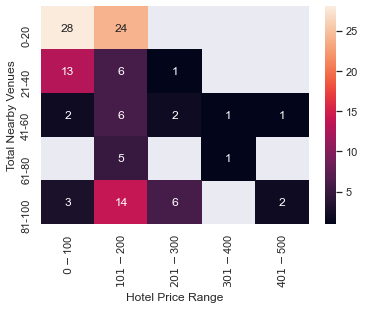

In [92]:
sns.heatmap(ranges_wide, annot=True)
plt.xlabel('Hotel Price Range')
plt.ylabel('Total Nearby Venues')

The purpose of the heatmap was to identify if there was a relationship between price and number of venues. For example, are higher priced hotels more likely to be surrounded by a large number of venues? The heatmap shows that hotels that are $200 or less are more likely to have less than 20 nearby venues. Hotels greater than $200 were more likely to have 80-100 nearby venues and were never in areas with less than 20 venues. There were some hotels that cost less than $200 a night that were in areas with 21-100 nearby venues.

### Data Analysis
Next, I used descriptive statistics to obtain the mean frequency each venue category was associated with each hotel. Then, I ran an analysis to identify the top 10 venues for each hotel. Last, I conducted a cluster analysis of hotels and their venues to find the hotels that had similar venues nearby.

In [93]:
# one hot encoding
hotel_onehot = pd.get_dummies(nearbyVenues2[['Venue Category']], prefix="", prefix_sep="")

# adding hotel name column back to dataframe
hotel_onehot['Hotel'] = nearbyVenues2['Name'] 

#adding borough name through merge, not sure I need this
#zips_onehot = pd.merge(dt_onehot, toronto_df[['PostalCode','Borough']], on='PostalCode')

# move Hotel column to the first column
col_name = 'Hotel'
first_col = hotel_onehot.pop(col_name)
hotel_onehot.insert(0, col_name, first_col)

hotel_onehot.head()

,Hotel,Accessories Store,Adult Boutique,Afghan Restaurant,Airport Terminal,American Restaurant,Antique Shop,Aquarium,Arepa Restaurant,Art Gallery,...,Video Game Store,Video Store,Vietnamese Restaurant,Warehouse Store,Whisky Bar,Wine Bar,Wings Joint,Women's Store,Xinjiang Restaurant,Yoga Studio
0,Bond Place Hotel,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Bond Place Hotel,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,Bond Place Hotel,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Bond Place Hotel,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,Bond Place Hotel,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [94]:
#grouping rows by hotel and getting mean frequency
hotel_grouped = hotel_onehot.groupby('Hotel').mean().reset_index()
hotel_grouped.head()

,Hotel,Accessories Store,Adult Boutique,Afghan Restaurant,Airport Terminal,American Restaurant,Antique Shop,Aquarium,Arepa Restaurant,Art Gallery,...,Video Game Store,Video Store,Vietnamese Restaurant,Warehouse Store,Whisky Bar,Wine Bar,Wings Joint,Women's Store,Xinjiang Restaurant,Yoga Studio
0,Alexandra Hotel,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.02,0.01,...,0.0,0.0,0.010000,0.0,0.0,0.01,0.0,0.0,0.0,0.02
1,Alt Hotel Toronto Airport,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.00,0.00,...,0.0,0.0,0.000000,0.0,0.0,0.00,0.0,0.0,0.0,0.00
2,Best Western Parkway Hotel Toronto North,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.00,0.00,...,0.0,0.0,0.020833,0.0,0.0,0.00,0.0,0.0,0.0,0.00
3,Best Western Plus Executive Inn,0.0,0.0,0.0,0.0,0.142857,0.0,0.0,0.00,0.00,...,0.0,0.0,0.000000,0.0,0.0,0.00,0.0,0.0,0.0,0.00
4,Best Western Plus Toronto Airport Hotel,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.00,0.00,...,0.0,0.0,0.000000,0.0,0.0,0.00,0.0,0.0,0.0,0.00


In [97]:

def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [98]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Hotel']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
hotel_venues_sorted = pd.DataFrame(columns=columns)
hotel_venues_sorted['Hotel'] = hotel_grouped['Hotel']

for ind in np.arange(hotel_grouped.shape[0]):
    hotel_venues_sorted.iloc[ind, 1:] = return_most_common_venues(hotel_grouped.iloc[ind, :], num_top_venues)

hotel_venues_sorted.head()

,Hotel,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Alexandra Hotel,Bar,Furniture / Home Store,Dessert Shop,Park,Pizza Place,Café,Yoga Studio,Gym / Fitness Center,Ice Cream Shop,Indian Restaurant
1,Alt Hotel Toronto Airport,Coffee Shop,Currency Exchange,Convenience Store,Frozen Yogurt Shop,Café,Yoga Studio,Farmers Market,Electronics Store,Ethiopian Restaurant,Event Space
2,Best Western Parkway Hotel Toronto North,Dessert Shop,Chinese Restaurant,Cantonese Restaurant,Indian Restaurant,Bank,Bakery,Dim Sum Restaurant,Middle Eastern Restaurant,Spanish Restaurant,Brazilian Restaurant
3,Best Western Plus Executive Inn,Sandwich Place,American Restaurant,Restaurant,Gas Station,Fast Food Restaurant,Sporting Goods Shop,Fish & Chips Shop,Filipino Restaurant,Fish Market,Donut Shop
4,Best Western Plus Toronto Airport Hotel,Sandwich Place,Middle Eastern Restaurant,Golf Course,Rental Service,Rental Car Location,Steakhouse,Fish & Chips Shop,Filipino Restaurant,Fast Food Restaurant,Farmers Market


In order to get an idea of how many clusters to look for when clustering hotels by common venue categories, I tested for the best number of clusters based on each hotel's latitude and longitude. My theory was that hotels located near each other would share similar types of venue categories nearby. The elbow curve revealed that the max number of clusters that explained the variance was 4 before leveling off and accounting for minimal variance.

**Elbow Curve of Kmeans Clusters for Hotels Based on Latitude and Longitude**

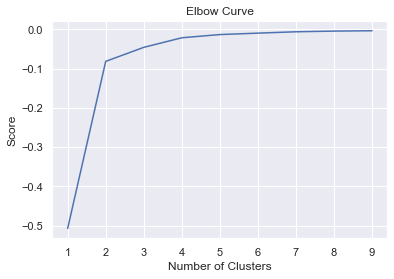

In [100]:
#next testing for potential clusters based on location to know how many clusters to use for above data
K_clusters = range(1,10)

kmeans = [KMeans(n_clusters=i) for i in K_clusters]

Y_axis = hoteldata_details2[['location.lat']]
X_axis = hoteldata_details2[['location.lng']]

score = [kmeans[i].fit(Y_axis).score(Y_axis) for i in range(len(kmeans))]

# Visualize
plt.plot(K_clusters, score)
plt.xlabel('Number of Clusters')
plt.ylabel('Score')
plt.title('Elbow Curve')
plt.show()

In [169]:
#going to use the point at which it starts to level off which is at 4.

# set number of clusters
kclusters = 4

hotel_grouped_clustering = hotel_grouped.drop('Hotel', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=10).fit(hotel_grouped_clustering)

# add clustering labels
hotel_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

In [170]:
hotel_venues_sorted.head()

,Cluster Labels,Hotel,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,2,Alexandra Hotel,Bar,Furniture / Home Store,Dessert Shop,Park,Pizza Place,Café,Yoga Studio,Gym / Fitness Center,Ice Cream Shop,Indian Restaurant
1,0,Alt Hotel Toronto Airport,Coffee Shop,Currency Exchange,Convenience Store,Frozen Yogurt Shop,Café,Yoga Studio,Farmers Market,Electronics Store,Ethiopian Restaurant,Event Space
2,2,Best Western Parkway Hotel Toronto North,Dessert Shop,Chinese Restaurant,Cantonese Restaurant,Indian Restaurant,Bank,Bakery,Dim Sum Restaurant,Middle Eastern Restaurant,Spanish Restaurant,Brazilian Restaurant
3,1,Best Western Plus Executive Inn,Sandwich Place,American Restaurant,Restaurant,Gas Station,Fast Food Restaurant,Sporting Goods Shop,Fish & Chips Shop,Filipino Restaurant,Fish Market,Donut Shop
4,2,Best Western Plus Toronto Airport Hotel,Sandwich Place,Middle Eastern Restaurant,Golf Course,Rental Service,Rental Car Location,Steakhouse,Fish & Chips Shop,Filipino Restaurant,Fast Food Restaurant,Farmers Market


After running the kmeans cluster analysis of 4 clusters and adding the cluster labels to the venue data, there were some additional cleaning steps to take. I identified which variables I wanted to keep from the hotel details data. I decided to keep the hotel name, address, price, id, latitude, longitude, url, rating, phone, and likes. Then I merged the venue data with the hotel data to have one master dataset. I used this master dataset to create the cluster map of the hotels.

In [106]:
pd.set_option('display.max_columns', None)
hoteldata_details2.head()

,Name,Address,Price,id,location.lat,location.lng,response.venue.name,response.venue.url,response.venue.rating,response.venue.contact.phone,response.venue.contact.formattedPhone,response.venue.contact.twitter,response.venue.contact.facebook,response.venue.contact.facebookUsername,response.venue.contact.facebookName,response.venue.contact.instagram,response.venue.hours.status,response.venue.hours.richStatus.entities,response.venue.hours.richStatus.text,response.venue.hours.isOpen,response.venue.hours.isLocalHoliday,response.venue.hours.dayData,response.venue.hours.timeframes,response.venue.defaultHours.status,response.venue.defaultHours.richStatus.entities,response.venue.defaultHours.richStatus.text,response.venue.defaultHours.isOpen,response.venue.defaultHours.isLocalHoliday,response.venue.defaultHours.dayData,response.venue.defaultHours.timeframes,response.venue.likes.count,response.venue.likes.groups,response.venue.likes.summary
0,Bond Place Hotel,"65 Dundas St E, Toronto, ON, M5B2G8, Canada",81,4ad4c05bf964a520a3f520e3,43.656188,-79.378452,Bond Place Hotel,http://www.bondplace.ca,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,52,"[{'type': 'others', 'count': 52, 'items': []}]",52 Likes
1,Pantages Hotel Downtown Toronto,"200 Victoria St, Toronto, ON, M5B 1V8, Canada",132,4ae61cf6f964a520caa421e3,43.654498,-79.379035,Pantages Hotel & Spa,NaN,6.7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,27,"[{'type': 'others', 'count': 27, 'items': []}]",27 Likes
2,Marriott Downtown at CF Toronto Eaton Centre,"525 Bay St, Toronto, ON, M5G 2L2, Canada",161,4b0563c0f964a5200e5822e3,43.654728,-79.382422,Marriott Downtown at CF Toronto Eaton Centre,https://www.marriott.com/hotels/travel/yyzec-m...,7.5,4165979200,(416) 597-9200,torontomarriott,113265185397835,marriotteatoncentre,Marriott Downtown CF Eaton Centre,NaN,Open,[],Open,True,False,[],"[{'days': 'Mon–Sun', 'includesToday': True, 'o...",Open,[],Open,True,False,[],"[{'days': 'Mon–Sun', 'includesToday': True, 'o...",84,"[{'type': 'others', 'count': 84, 'items': []}]",84 Likes
3,"Chelsea Hotel, Toronto","33 Gerrard St W, Toronto, ON, M5G1Z4, Canada",129,51e48697498eded9073c6c17,43.658094,-79.382711,Crew Room Eaton Chelsea Hotel,NaN,6.4,8002435732,(800) 243-5732,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5,"[{'type': 'others', 'count': 5, 'items': [{'id...",5 Likes
4,DoubleTree by Hilton Hotel Toronto Downtown,"108 Chestnut St, Toronto, ON, M5G1R3, Canada",132,52ce14b0498e50457ce11780,43.654608,-79.385942,DoubleTree by Hilton,https://doubletree3.hilton.com/en/hotels/ontar...,7.7,4169775000,(416) 977-5000,doubletree,388870797917523,DoubleTreeTorontoDowntown,DoubleTree by Hilton Toronto Downtown,NaN,Open,[],Open,True,False,[],"[{'days': 'Mon–Sun', 'includesToday': True, 'o...",Open,[],Open,True,False,[],"[{'days': 'Mon–Sun', 'includesToday': True, 'o...",80,"[{'type': 'others', 'count': 80, 'items': []}]",80 Likes


In [110]:
#need to do some cleaning before merging
hoteldata_details3 = hoteldata_details2.rename(columns={'Name':'Hotel',
                                                        'location.lat':'Latitude',
                                                        'location.lng':'Longitude',
                                                        'response.venue.url':'URL',
                                                        'response.venue.rating':'Rating',
                                                        'response.venue.contact.formattedPhone':'Phone',
                                                        'response.venue.likes.count':'LikesCount',
                                                        'response.venue.likes.summary':'LikesSummary'})

hoteldata_details4 = hoteldata_details3[['Hotel', 'Address', 'Price', 'id', 'Latitude', 'Longitude', 'URL', 'Rating', 'Phone', 'LikesCount', 'LikesSummary']]
hoteldata_details4.head()


,Hotel,Address,Price,id,Latitude,Longitude,URL,Rating,Phone,LikesCount,LikesSummary
0,Bond Place Hotel,"65 Dundas St E, Toronto, ON, M5B2G8, Canada",81,4ad4c05bf964a520a3f520e3,43.656188,-79.378452,http://www.bondplace.ca,5.0,NaN,52,52 Likes
1,Pantages Hotel Downtown Toronto,"200 Victoria St, Toronto, ON, M5B 1V8, Canada",132,4ae61cf6f964a520caa421e3,43.654498,-79.379035,NaN,6.7,NaN,27,27 Likes
2,Marriott Downtown at CF Toronto Eaton Centre,"525 Bay St, Toronto, ON, M5G 2L2, Canada",161,4b0563c0f964a5200e5822e3,43.654728,-79.382422,https://www.marriott.com/hotels/travel/yyzec-m...,7.5,(416) 597-9200,84,84 Likes
3,"Chelsea Hotel, Toronto","33 Gerrard St W, Toronto, ON, M5G1Z4, Canada",129,51e48697498eded9073c6c17,43.658094,-79.382711,NaN,6.4,(800) 243-5732,5,5 Likes
4,DoubleTree by Hilton Hotel Toronto Downtown,"108 Chestnut St, Toronto, ON, M5G1R3, Canada",132,52ce14b0498e50457ce11780,43.654608,-79.385942,https://doubletree3.hilton.com/en/hotels/ontar...,7.7,(416) 977-5000,80,80 Likes


In [175]:
hotel_merged = pd.merge(hoteldata_details4, hotel_venues_sorted, on='Hotel', how='inner')
print(hotel_merged.shape)
hotel_merged.head()

(115, 22)


,Hotel,Address,Price,id,Latitude,Longitude,URL,Rating,Phone,LikesCount,LikesSummary,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Bond Place Hotel,"65 Dundas St E, Toronto, ON, M5B2G8, Canada",81,4ad4c05bf964a520a3f520e3,43.656188,-79.378452,http://www.bondplace.ca,5.0,NaN,52,52 Likes,2,Clothing Store,Coffee Shop,Japanese Restaurant,Cosmetics Shop,Italian Restaurant,Plaza,Tea Room,Café,Theater,Sandwich Place
1,Pantages Hotel Downtown Toronto,"200 Victoria St, Toronto, ON, M5B 1V8, Canada",132,4ae61cf6f964a520caa421e3,43.654498,-79.379035,NaN,6.7,NaN,27,27 Likes,2,Clothing Store,Italian Restaurant,Coffee Shop,Plaza,Cosmetics Shop,Seafood Restaurant,Café,Gym,Lingerie Store,Fast Food Restaurant
2,Marriott Downtown at CF Toronto Eaton Centre,"525 Bay St, Toronto, ON, M5G 2L2, Canada",161,4b0563c0f964a5200e5822e3,43.654728,-79.382422,https://www.marriott.com/hotels/travel/yyzec-m...,7.5,(416) 597-9200,84,84 Likes,2,Coffee Shop,Clothing Store,Plaza,Middle Eastern Restaurant,Italian Restaurant,Seafood Restaurant,Pizza Place,Restaurant,Tanning Salon,Diner
3,"Chelsea Hotel, Toronto","33 Gerrard St W, Toronto, ON, M5G1Z4, Canada",129,51e48697498eded9073c6c17,43.658094,-79.382711,NaN,6.4,(800) 243-5732,5,5 Likes,2,Coffee Shop,Italian Restaurant,Bubble Tea Shop,Japanese Restaurant,Burger Joint,Ramen Restaurant,Tea Room,Clothing Store,Fast Food Restaurant,Sandwich Place
4,DoubleTree by Hilton Hotel Toronto Downtown,"108 Chestnut St, Toronto, ON, M5G1R3, Canada",132,52ce14b0498e50457ce11780,43.654608,-79.385942,https://doubletree3.hilton.com/en/hotels/ontar...,7.7,(416) 977-5000,80,80 Likes,2,Clothing Store,Coffee Shop,Electronics Store,Plaza,Cosmetics Shop,Middle Eastern Restaurant,Food Court,Café,Sushi Restaurant,Poke Place


**Map of Hotel Clusters in Toronto Based on Most Common Nearby Venue Categories**

In [176]:
map_clusters2 = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(hotel_merged['Latitude'], hotel_merged['Longitude'], hotel_merged['Hotel'], hotel_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters2)
       
map_clusters2    

In [113]:
#hotel_merged.to_csv('hotel_merged.csv', index=False)

## Results

The K-means clustering analysis and visual representation show groups of hotels based on nearby venue categories. The largest cluster appears blue on the map. In order to get an idea of potential differences between clusters, I examined the total number of venue categories associated with each cluster.

There were 76 hotels within the blue cluster contained a wide variety of places to eat and things to do. Common places included coffee shops and cafes, a variety of places to eat, shopping, gyms, spas, and bars. If someone wanted to stay at a hotel near a variety of things to do and place to eat, hotels in the blue cluster would be the place to stay. 

In addition, these hotels were not located in one area of Toronto. While many were in downtown Toronto, there were plenty of choices near the airport, Vaughn, and Markham. Depending on people's reasons to visit Toronto, they would likely find a hotel with a variety of options nearby. Hotel prices in this cluster ranged from $40 to $453. The average hotel price was $142.97. Fifty-percent of the hotels in this cluster were less than $125. The average rating for hotels in this cluster was 7.0 and the average number of likes was 50.

In [177]:
blue = hotel_merged.loc[hotel_merged['Cluster Labels'] == 2, hotel_merged.columns[[0] + list(range(12, hotel_merged.shape[1]))]]
blue_long = blue.drop(['Hotel'], 1).melt(var_name = 'columns', value_name='type')
blue_counts = blue_long['type'].value_counts().rename_axis('Type').reset_index(name='Count')



,Type,Count
0,Coffee Shop,51
1,Restaurant,34
2,Café,33
3,Italian Restaurant,33
4,Japanese Restaurant,28
5,Sandwich Place,22
6,Sushi Restaurant,19
7,Pizza Place,18
8,Gym,16
9,Clothing Store,15


In [185]:
blue_counts[blue_counts['Count'] >= 10]

,Type,Count
0,Coffee Shop,51
1,Restaurant,34
2,Café,33
3,Italian Restaurant,33
4,Japanese Restaurant,28
5,Sandwich Place,22
6,Sushi Restaurant,19
7,Pizza Place,18
8,Gym,16
9,Clothing Store,15


In [214]:
InfobyCluster = hotel_merged[['Hotel', 'Price', 'Cluster Labels', 'Rating', 'LikesCount']]
InfobyCluster2 = InfobyCluster[InfobyCluster['Cluster Labels']==2]
InfobyCluster2[['Price', 'Rating', 'LikesCount']].describe()

,Price,Rating,LikesCount
count,76.000000,63.000000,76.000000
mean,142.973684,7.004762,50.342105
std,85.973945,1.111730,76.482948
min,40.000000,4.800000,0.000000
25%,88.000000,6.300000,7.000000
50%,124.500000,7.200000,20.000000
75%,158.750000,7.900000,54.250000
max,453.000000,9.200000,395.000000


The purple cluster consisted of 21 hotels. While there was still some variety, there are not as many options as the blue cluster. Travelers who may stay in these locations may be coming to the area for work for example. They may have less time for sight seeing and participating in a variety of activities in the area but still want a couple of different places to eat when they are not working. This cluster is more likely to have rental car stores and gas stations making it convenient to pick up and drop off rental cars.

The hotels in this cluster are less expensive than the blue cluster. They range in price from $66 to $189. The average price is $105.19 and half of the hotels were less than $106. The average rating for hotels in this cluster was 6.1, and the average number of likes was 16.

In [180]:
purple = hotel_merged.loc[hotel_merged['Cluster Labels'] == 1, hotel_merged.columns[[0] + list(range(12, hotel_merged.shape[1]))]]
purple_long = purple.drop(['Hotel'], 1).melt(var_name = 'columns', value_name='type')
purple_counts = purple_long['type'].value_counts().rename_axis('Type').reset_index(name='Count')

In [181]:
purple_counts[purple_counts['Count'] >= 5]

,Type,Count
0,Restaurant,21
1,Coffee Shop,17
2,Sandwich Place,15
3,American Restaurant,11
4,Steakhouse,10
5,Rental Car Location,9
6,Italian Restaurant,7
7,Fast Food Restaurant,7
8,Japanese Restaurant,6
9,Electronics Store,6


In [215]:
InfobyCluster1 = InfobyCluster[InfobyCluster['Cluster Labels']==1]
InfobyCluster1[['Price', 'Rating', 'LikesCount']].describe()

,Price,Rating,LikesCount
count,21.000000,16.000000,21.000000
mean,105.190476,6.075000,16.904762
std,28.711703,0.784432,15.013010
min,66.000000,4.800000,0.000000
25%,82.000000,5.500000,5.000000
50%,106.000000,6.000000,14.000000
75%,119.000000,6.525000,24.000000
max,189.000000,7.600000,44.000000


There were 13 hotels in the red cluster. The red cluster consisted of only two types of places to eat: sandwich places and Ethiopian restaurants. There are plenty of coffee shops. Those who stay in these hotels may choose these hotels because they are attending something at an event space. However, it would be important for them to know before booking their hotels that there are not a lot of places to eat within walking distance and may need to drive to get more variety when eating or if they need to shop.

Given the lack of variety nearby, it was surprising that the hotel price ranges were from $59 to $348. The high price of hotels are likely due to the Event spaces. The average price for a hotel in this cluster was $123.46. Half of the hotels in this cluster were $98 or below. The average rating was 6.7, and the average number of likes was 20.

In [178]:
red = hotel_merged.loc[hotel_merged['Cluster Labels'] == 0, hotel_merged.columns[[0] + list(range(12, hotel_merged.shape[1]))]]
red_long = red.drop(['Hotel'], 1).melt(var_name = 'columns', value_name='type')
red_counts = red_long['type'].value_counts().rename_axis('Type').reset_index(name='Count')

In [179]:
red_counts[red_counts['Count'] >= 5]

,Type,Count
0,Coffee Shop,13
1,Electronics Store,7
2,Sandwich Place,7
3,Farmers Market,6
4,Ethiopian Restaurant,6
5,Event Space,6
6,Yoga Studio,5


In [216]:
InfobyCluster0 = InfobyCluster[InfobyCluster['Cluster Labels']==0]
InfobyCluster0[['Price', 'Rating', 'LikesCount']].describe()

,Price,Rating,LikesCount
count,13.000000,11.000000,13.000000
mean,123.461538,6.654545,19.769231
std,80.536343,1.020160,19.344051
min,59.000000,5.100000,1.000000
25%,79.000000,6.050000,2.000000
50%,98.000000,6.600000,14.000000
75%,124.000000,7.300000,26.000000
max,348.000000,8.200000,59.000000


The final and smallest cluster was the yellow cluster. There were only 5 hotels in this cluster. While there were only a few hotels, there was a decent variety of restaurants with some places to shop. In addition, while there were at most two event spaces in this cluster, the prices for the hotels were less expensive compared to the red cluster which also had event spaces. 

The hotels ranged in price from $80 to $119 with an average of $93.80. Half of the hotels in this cluster were $87 or less. The average rating for hotels in this cluster was 6.4, and the average number of likes was 23.

In [182]:
yellow = hotel_merged.loc[hotel_merged['Cluster Labels'] == 3, hotel_merged.columns[[0] + list(range(12, hotel_merged.shape[1]))]]
yellow_long = yellow.drop(['Hotel'], 1).melt(var_name = 'columns', value_name='type')
yellow_counts = yellow_long['type'].value_counts().rename_axis('Type').reset_index(name='Count')

In [184]:
yellow_counts[yellow_counts['Count'] >= 2]

,Type,Count
0,Gas Station,5
1,American Restaurant,4
2,Café,4
3,Breakfast Spot,3
4,Fish Market,3
5,Flower Shop,3
6,Italian Restaurant,3
7,Coffee Shop,3
8,Flea Market,3
9,Falafel Restaurant,2


In [217]:
InfobyCluster3 = InfobyCluster[InfobyCluster['Cluster Labels']==3]
InfobyCluster3[['Price', 'Rating', 'LikesCount']].describe()

,Price,Rating,LikesCount
count,5.000000,4.000000,5.000000
mean,93.800000,6.425000,23.400000
std,15.188812,0.925113,20.525594
min,80.000000,5.400000,3.000000
25%,87.000000,5.925000,5.000000
50%,87.000000,6.350000,23.000000
75%,96.000000,6.850000,34.000000
max,119.000000,7.600000,52.000000


## Discussion

The results of this analysis show that the combination of foursquare data and hotel price data can help travelers make an informed decision on the best place to stay for their trips. Toronto, Canada was used as a test case in this analysis to determine if it was possible segment hotels based on the types of venues near hotels and then provide travelers with additional information about estimated hotel price, ratings, and likes. 

Hotels in Toronto fell into four different groups. A majority of the hotels (66%) were in the blue cluster which had a lot of variety in terms of eating, drinking, and things to do within walking distance. For travelers who may not want to rent a car and plan to stay within walking distance of their hotel should choose hotels in the blue cluster. There was a wide range of hotel prices within the blue cluster giving travelers with different sized budgets access to these hotels.

Eighteen percent of hotels fell within the purple cluster. These hotels also had some variety for eating and caffinated drinks. These hotels may be ideal for short work trips where a traveler just needs some of the basics (e.g., food and drink) for their stay. These hotels ranged on the lower end of hotel prices.

Eleven percent of hotels fell in the red cluster. These hotels had plenty of coffee shops, but only limited types of places to eat. If someone had to stay in a hotel in this cluster, whether because hotels in the other cluster were sold out or they wanted to be near an event venue, they would at least know they may need a rental car or some sort of transportation for any dining, drinking, or shopping needs. The price range for these hotels was almost as big as hotels in the blue cluster. The higher priced hotels may be due to their proximity to event venues making it even more important for travelers to know that while they are paying a high price for a hotel, there are few venues within walking distance.

The fourth and smallest group consisted of hotels (4%) in the yellow cluster. Surprisingly, these hotels had a variety in terms of eating and shopping and were in the lower range of hotel prices. Most of the hotels in this cluster were near the airport, which means there is some variety of places to eat within walking distance when a traveler wants to stay near the airport. 


In [206]:
hotel_merged.shape
print("Percent of hotels in blue cluster: " + str(round(len(blue.index)/len(hotel_merged.index), 2)*100) + "%")
print("Percent of hotels in purple cluster: " + str(round(len(purple.index)/len(hotel_merged.index), 2)*100) + "%")
print("Percent of hotels in red cluster: " + str(round(len(red.index)/len(hotel_merged.index), 2)*100) + "%")
print("Percent of hotels in yellow cluster: " + str(round(len(yellow.index)/len(hotel_merged.index), 2)*100) + "%")

Percent of hotels in blue cluster: 66.0%
Percent of hotels in purple cluster: 18.0%
Percent of hotels in red cluster: 11.0%
Percent of hotels in yellow cluster: 4.0%


## Conclusion

A traveler coming to Toronto will probably want to focus on the hotels in the blue cluster as their first choice. Hotels in this cluster are located in various places throughout Toronto, and have a variety of prices to appeal to any budget. On average, they are more highly rated and have more likes than hotels in the other clusters. These hotels also have a variety of drinking, dining, shopping, and activities within walking distance. 

If a traveler isn't able to book a hotel within the blue cluster, the next best cluster of hotels would be the red ones. These had the second highest average ratings and a range of prices that would appeal to any budget. The one downside to hotels in this cluster was that there were not a lot of places to eat nearby or things to do. A traveler staying here would need to have some transportation if they wanted some variety in drinking, dining, shopping, and/or activities.

This would be a useful feature for travel companies to offer their travel clients. By using a combination of detailed foursquare data and hotel price data, they could provide an interactive map that shows the different hotel clusters. The map provides an easy way for travelers to focus on a particular area and then choose a hotel where a pop-up reveals the name, price, rating, likes, hotel phone, and hotel URL. 

**Map of Toronto Hotels by Cluster**

In [218]:
map_clusters3 = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster, price, rating, likes, phone, url in zip(hotel_merged['Latitude'], hotel_merged['Longitude'], hotel_merged['Hotel'], hotel_merged['Cluster Labels'], hotel_merged['Price'], hotel_merged['Rating'], hotel_merged['LikesSummary'], hotel_merged['Phone'], hotel_merged['URL']):
    label = folium.Popup(str(poi) + ', $' + str(price) + ', ' +str(rating) + ', ' + str(likes)  + ', ' + str(phone) + ', ' +str(url), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters3)
       
map_clusters3  